In [1]:
# Environment Setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from captum.attr import IntegratedGradients, Occlusion
import warnings
import re
from glob import glob
from tensorflow.keras.utils import to_categorical
import random

import numpy as np
import torch

warnings.filterwarnings('ignore')

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


In [2]:

import os
if os.path.isfile("myData.npz"):
    print("✅ Loading preprocessed features...")
    with np.load("myData.npz") as data:
        myData = data['myData']
        myData2 = data['myData2']
        myY = data['myY']
        myActors = data['myActors']
        myDatasets = data['myDatasets']
        myPaths = data['myPaths']

    print(f"Mel spectrograms shape: {myData.shape}")
    print(f"Topological features shape: {myData2.shape}")
    print(f"Labels shape: {myY.shape}")
    print(f"Number of unique actors: {len(np.unique(myActors))}")
    print(f"Number of unique datasets: {len(np.unique(myDatasets))}")
else:
    folder = './savefiles3'

    def findFilesFromPattern(pattern):
        pattern = re.compile(pattern + r'_(.*?)_(.*?)_(.*?)_(\d+)_(\d+)\.npy')
        heatmaps_dict = {}

        for filename in os.listdir(folder):
            match = pattern.match(filename)
            if match:
                dataset, actor, emotion, i, j = map(str, match.groups())
                i, j = int(i), int(j)
                filepath = os.path.join(folder, filename)
                data = np.load(filepath)

                heatmaps_dict[f'{dataset}_{actor}_{emotion}_{j // 2}_{j%2}'] = {'data': data, 'dataset': dataset, 'actor': actor, 'emotion':emotion, 'type': j}

        return heatmaps_dict

    melwasserstein = findFilesFromPattern('wassersteinHeat')
    meltimeeuclid = findFilesFromPattern('timeMetricHeat')
    meleuclid = findFilesFromPattern('euclideanHeat')

    def load_spectrograms(prefixes, path='./savefiles3'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.npy"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [np.load(file) for i, file in enumerate(file_list)]

    def load_audio_paths(prefixes, path='./savefiles3'):
        patterns = []
        for prefix in prefixes:
            patterns.append(os.path.join(path, f"{prefix}_*.wav"))
        my_globs = glob(patterns[0])
        for pattern in patterns[1:]:
            my_globs = my_globs + glob(pattern)
        file_list = sorted(my_globs)
        return [file for i, file in enumerate(file_list)]


    myRaw = load_spectrograms(["savee", 'tess', 'radvess', 'cremad'])
    myPaths = load_audio_paths(["sounds_savee", 'sounds_tess', 'sounds_radvess', 'sounds_cremad'])
    print(len(melwasserstein))
    print(len([melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0]))
    print(len([melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]))
    print(np.array([[meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] == 0]]).shape)

    print(len(myRaw))
    print(len(myPaths))

    myData = np.array([myRaw])
    print('finish data')
    myData = myData.astype('float32')
    myData = np.transpose(myData, (1, 2, 3, 0))
    myEmotionMap = {
        'neutral': 1, 'happy':2, 'sad':3, 'angry':4, 'fearful':5, 'disgust':6, 'calm':7, 'surprised':8
    }
    myY = np.array(
        [myEmotionMap[melwasserstein[key]['emotion']] -1 for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0]
    )
    myActors = np.array(
        [melwasserstein[key]['actor'] + '_' + melwasserstein[key]['dataset']  for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0]
    )
    myDatasets = np.array(
        [melwasserstein[key]['dataset']  for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0]
    )
    print(np.unique(myActors))

    print(np.unique(myY))

    myY = to_categorical(myY, num_classes=6)

    myData2 = np.array([
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 0],
                        [meleuclid[key]['data'] for key in sorted(meleuclid.keys()) if meleuclid[key]['type'] % 2 == 1],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 0],
                        [meltimeeuclid[key]['data'] for key in sorted(meltimeeuclid.keys()) if meltimeeuclid[key]['type'] % 2 == 1],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 0],
                        [melwasserstein[key]['data'] for key in sorted(melwasserstein.keys()) if melwasserstein[key]['type'] % 2 == 1]
                        ])
    print('finish data')
    myData2 = myData2.astype('float32')
    print(myData2.shape)
    myData2 = np.transpose(myData2, (1, 2, 3, 0))
    print(myData2.shape)
    np.savez_compressed(
        "myData.npz",
        myData=myData,
        myData2=myData2,
        myY=myY,
        myActors=myActors,
        myDatasets=myDatasets,
        myPaths=myPaths,
    )

✅ Loading preprocessed features...
Mel spectrograms shape: (11318, 128, 256, 1)
Topological features shape: (11318, 32, 32, 6)
Labels shape: (11318, 6)
Number of unique actors: 121
Number of unique datasets: 4


Generating topological feature visualizations...


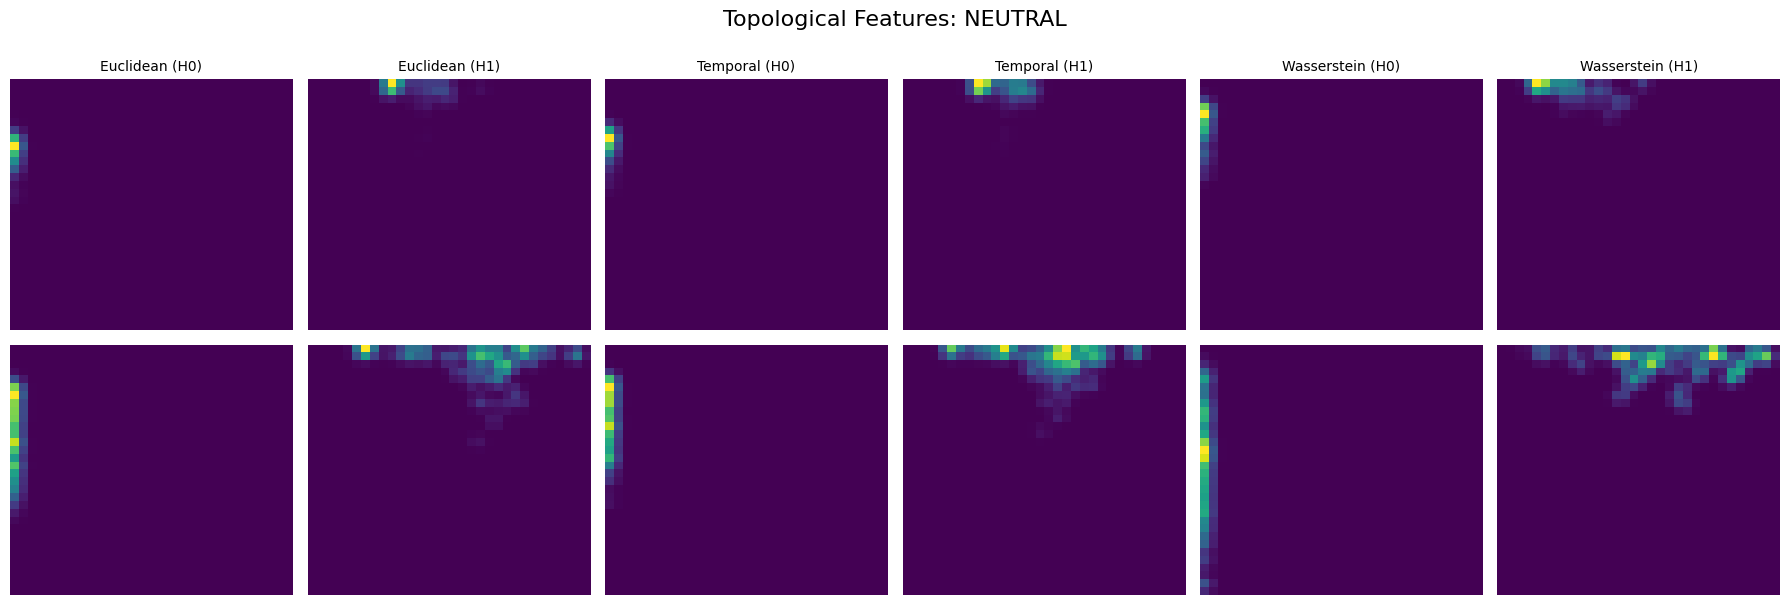

Saved: topology_neutral.png



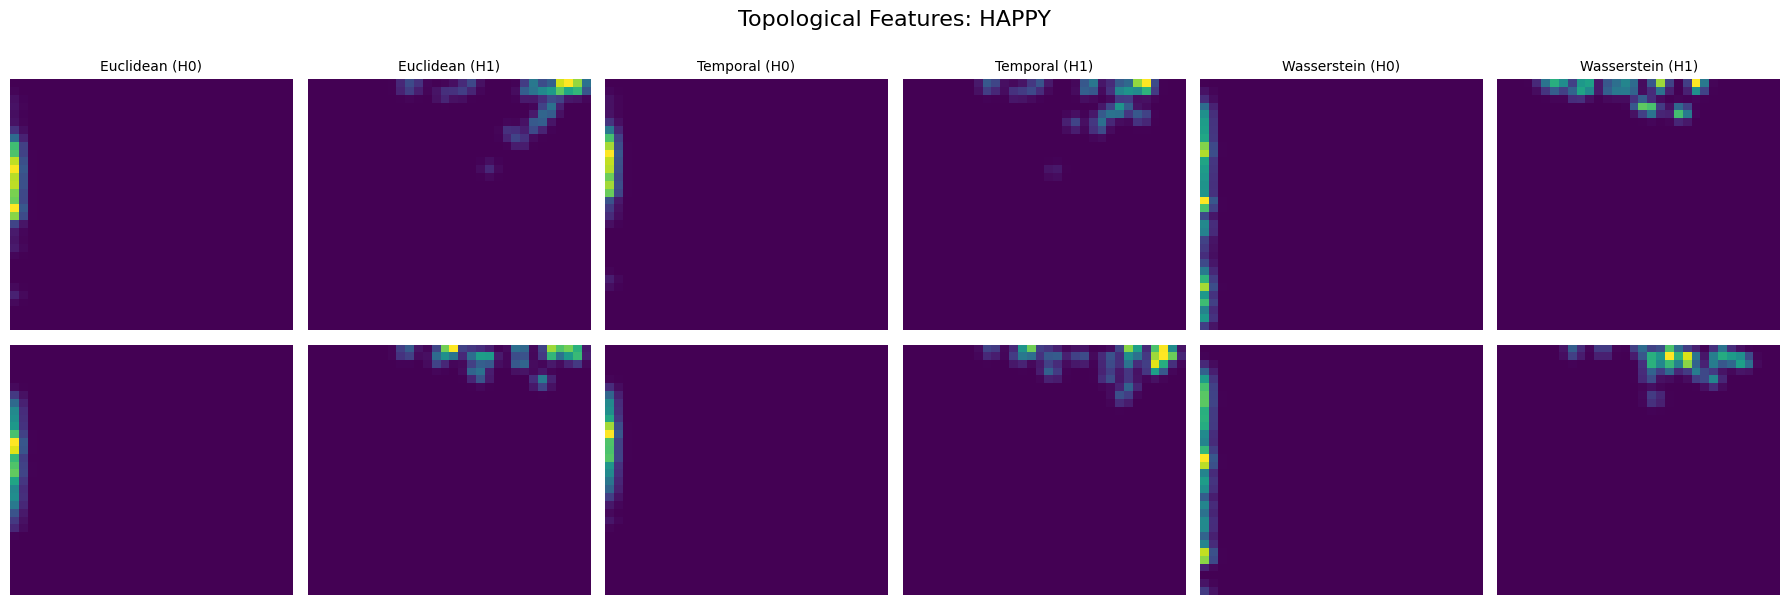

Saved: topology_happy.png



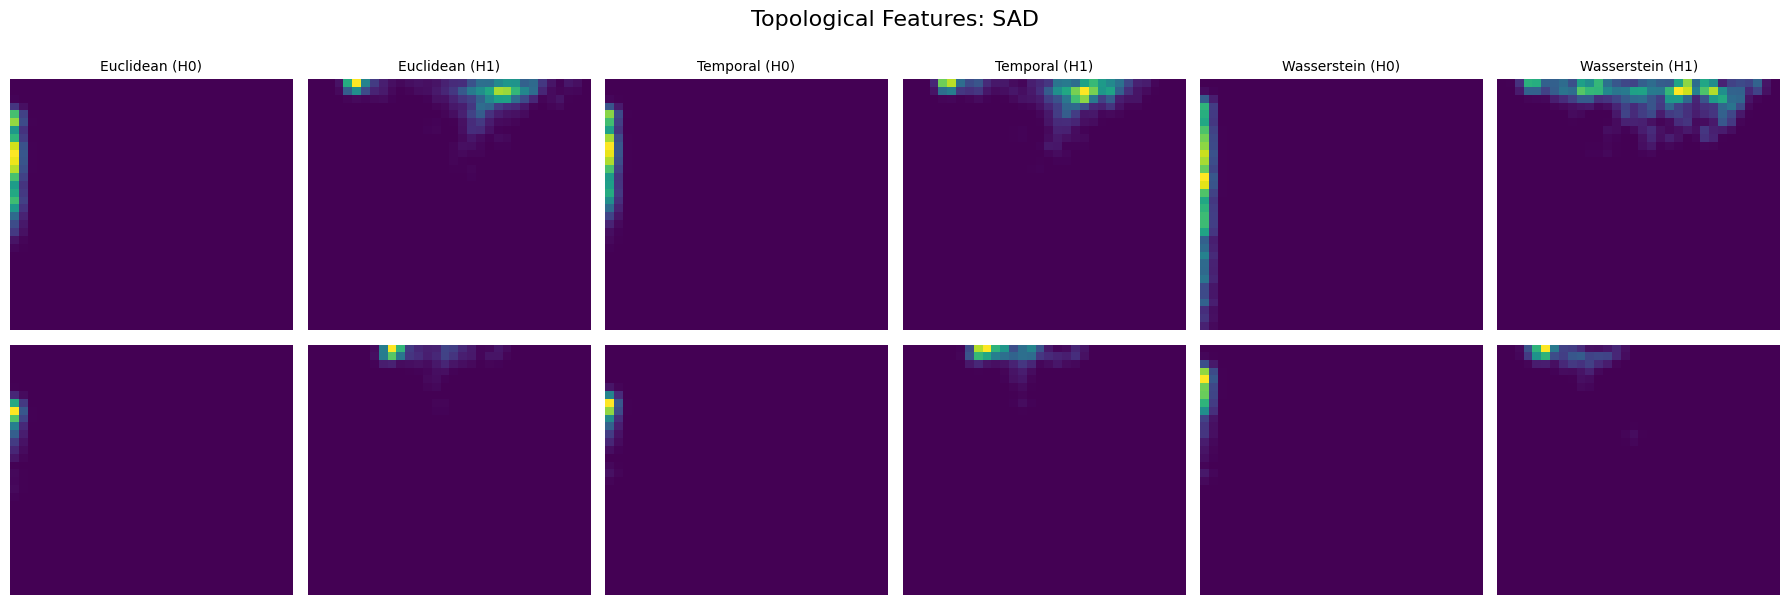

Saved: topology_sad.png



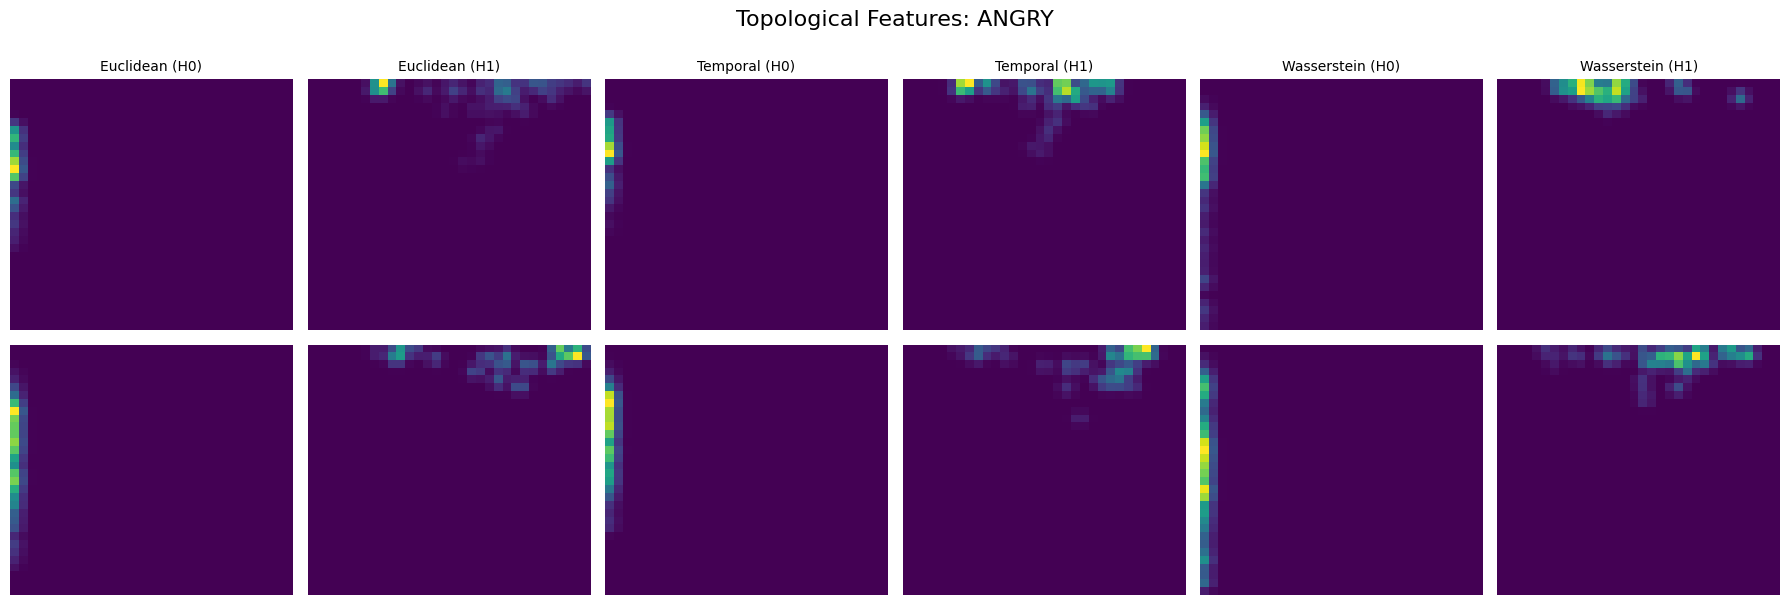

Saved: topology_angry.png



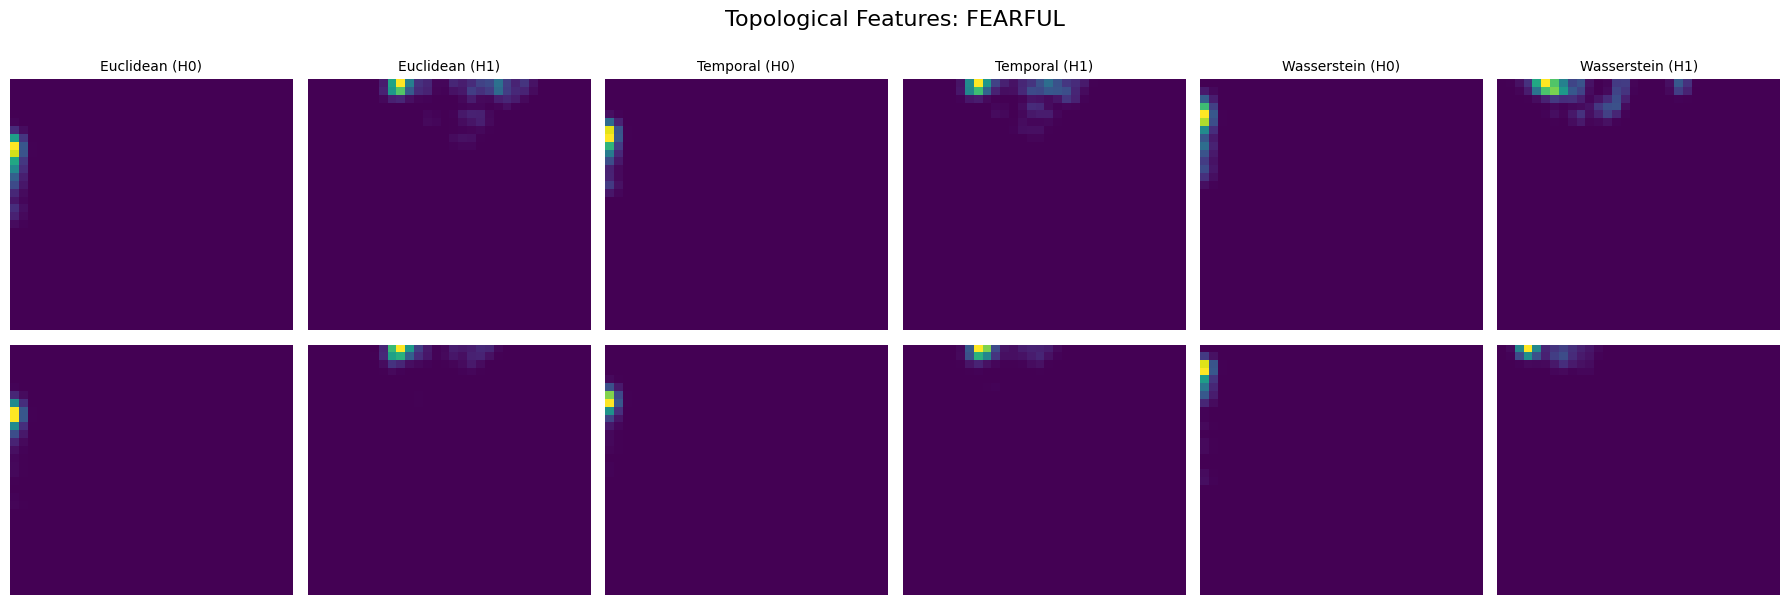

Saved: topology_fearful.png



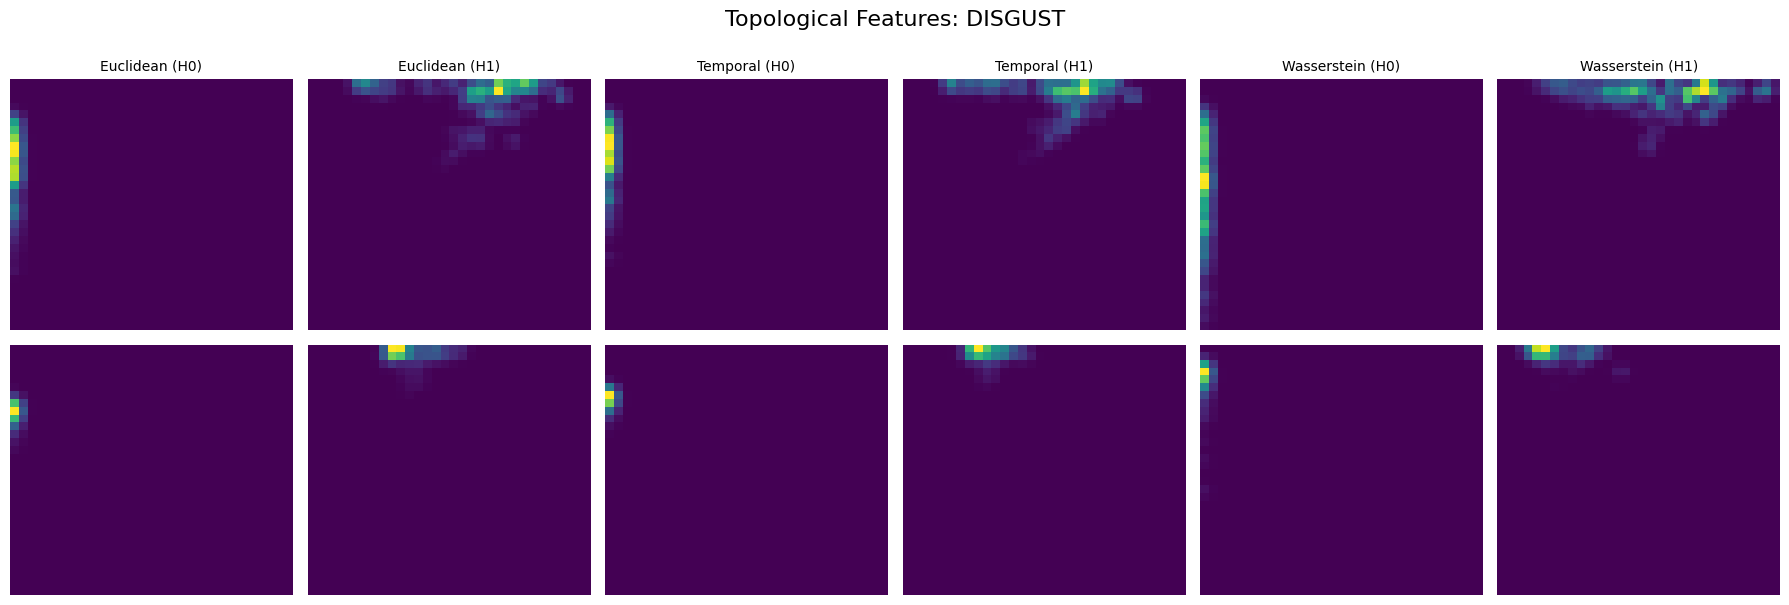

Saved: topology_disgust.png



In [3]:

def visualize_topological_channels(data, labels, actors, num_samples=3):
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]

    label_ids = np.argmax(labels, axis=1)

    for emotion_id in range(6):
        emotion_mask = label_ids == emotion_id
        emotion_samples = data[emotion_mask]

        indices = np.random.choice(len(emotion_samples), min(num_samples, len(emotion_samples)), replace=False)

        fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))
        fig.suptitle(f'Topological Features: {emotions[emotion_id].upper()}', fontsize=16, y=1.00)

        for row, idx in enumerate(indices):
            sample = emotion_samples[idx]
            for col in range(6):
                ax = axes[row, col] if num_samples > 1 else axes[col]
                ax.imshow(sample[:, :, col], cmap='viridis', aspect='auto')
                if row == 0:
                    ax.set_title(channel_names[col], fontsize=10)
                ax.axis('off')

        plt.tight_layout()
        plt.savefig(f'topology_{emotions[emotion_id]}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved: topology_{emotions[emotion_id]}.png\n")

if 'myData2' in locals():
    print("Generating topological feature visualizations...")
    visualize_topological_channels(myData2, myY, myActors, num_samples=2)

In [4]:
class MelSpectrogramCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(MelSpectrogramCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

class TopologicalCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(TopologicalCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, return_embedding=False):
        f = self.features(x)
        z = self.classifier[:-1](f)
        logits = self.classifier[-1](z)
        return z if return_embedding else logits


class CombinedFusionModel(nn.Module):

    def __init__(self, num_classes=6):
        super(CombinedFusionModel, self).__init__()
        self.mel_branch = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )


        self.topo_branch = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, mel_input, topo_input):
        mel_emb = self.mel_branch(mel_input)
        topo_emb = self.topo_branch(topo_input)
        combined = torch.cat([mel_emb, topo_emb], dim=1)
        return self.classifier(combined)

print("✅ Model architectures defined")

✅ Model architectures defined


In [ ]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# HuggingFace
from transformers import AutoFeatureExtractor, WavLMModel

# Audio loading + resampling (robust)
try:
    import torchaudio
    _HAS_TORCHAUDIO = True
except Exception:
    _HAS_TORCHAUDIO = False

try:
    import soundfile as sf
    _HAS_SF = True
except Exception:
    _HAS_SF = False


class CRNNSpectrogram(nn.Module):
    """
    Simple CRNN baseline:
      CNN -> average over frequency -> BiGRU over time -> mean pool -> classifier
    Expects input: (B, 1, F, T)
    """
    def __init__(self, num_classes=6, rnn_hidden=128, rnn_layers=2, dropout=0.3):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (F/2, T/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (F/4, T/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Reduce frequency more than time to keep a usable sequence length
            nn.MaxPool2d(kernel_size=(2, 1)),  # (F/8, T/4)
            nn.Dropout(dropout),
        )

        # After averaging over frequency, GRU input_size == channels (128)
        self.gru = nn.GRU(
            input_size=128,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if rnn_layers > 1 else 0.0,
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2 * rnn_hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: (B, 1, F, T)
        x = self.cnn(x)              # (B, C=128, F', T')
        x = x.mean(dim=2)            # average over F' -> (B, 128, T')
        x = x.transpose(1, 2)        # (B, T', 128)

        out, _ = self.gru(x)         # (B, T', 2*rnn_hidden)
        out = out.mean(dim=1)        # mean pool over time -> (B, 2*rnn_hidden)

        return self.classifier(out)


import torch.nn as nn
import torchvision.models as models

class ResNet18Spectrogram(nn.Module):
    """
    ResNet-18 baseline adapted for 1-channel spectrogram input.
    Expects input: (B, 1, F, T)
    """
    def __init__(self, num_classes=6, pretrained=False):
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        self.net = models.resnet18(weights=weights)

        # Change first conv to accept 1 channel instead of 3
        self.net.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # Replace classifier head
        self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def forward(self, x):
        return self.net(x)

class AudioPathDataset(Dataset):
    def __init__(self, paths, labels, dataset_names=None, target_sr=16000, max_seconds=None):
        self.paths = list(paths)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.dataset_names = None if dataset_names is None else list(dataset_names)
        self.target_sr = int(target_sr)
        self.max_len = None if max_seconds is None else int(max_seconds * self.target_sr)

        if not _HAS_TORCHAUDIO and not _HAS_SF:
            raise RuntimeError("Need either torchaudio or soundfile installed to load audio.")

    def __len__(self):
        return len(self.paths)

    def _load_audio(self, path):
        # Returns mono waveform as float32 torch tensor [T] at target_sr
        if _HAS_TORCHAUDIO:
            wav, sr = torchaudio.load(path)  # [C, T]
            wav = wav.mean(dim=0)            # mono
            if sr != self.target_sr:
                wav = torchaudio.functional.resample(wav, sr, self.target_sr)
            wav = wav.to(torch.float32)
        else:
            wav_np, sr = sf.read(path, always_2d=False)
            if wav_np.ndim > 1:
                wav_np = wav_np.mean(axis=-1)
            wav = torch.tensor(wav_np, dtype=torch.float32)
            if sr != self.target_sr:
                # simple fallback resample (better to install torchaudio)
                import numpy as np
                import scipy.signal
                g = np.gcd(sr, self.target_sr)
                up = self.target_sr // g
                down = sr // g
                wav = torch.tensor(scipy.signal.resample_poly(wav.numpy(), up, down), dtype=torch.float32)

        # Optional truncation
        if self.max_len is not None and wav.numel() > self.max_len:
            wav = wav[:self.max_len]
        return wav

    def __getitem__(self, idx):
        wav = self._load_audio(self.paths[idx])
        y = self.labels[idx]
        if self.dataset_names is None:
            return wav, y
        return wav, y, self.dataset_names[idx]
def collate_wavlm_train(batch):
    # batch: list of (wav[T], y)
    wavs, ys = zip(*batch)
    lengths = torch.tensor([w.numel() for w in wavs], dtype=torch.long)
    max_len = int(lengths.max().item())

    X = torch.zeros(len(wavs), max_len, dtype=torch.float32)
    X2 = torch.zeros(len(wavs), max_len, dtype=torch.long)  # attention mask

    for i, w in enumerate(wavs):
        L = w.numel()
        X[i, :L] = w
        X2[i, :L] = 1

    y = torch.stack(list(ys)) if isinstance(ys[0], torch.Tensor) else torch.tensor(ys, dtype=torch.long)
    return X, X2, y


def collate_wavlm_test(batch):
    # batch: list of (wav[T], y, dataset_name)
    wavs, ys, names = zip(*batch)
    lengths = torch.tensor([w.numel() for w in wavs], dtype=torch.long)
    max_len = int(lengths.max().item())

    X = torch.zeros(len(wavs), max_len, dtype=torch.float32)
    X2 = torch.zeros(len(wavs), max_len, dtype=torch.long)

    for i, w in enumerate(wavs):
        L = w.numel()
        X[i, :L] = w
        X2[i, :L] = 1

    y = torch.stack(list(ys)) if isinstance(ys[0], torch.Tensor) else torch.tensor(ys, dtype=torch.long)
    return X, X2, y, list(names)

class WavLMClassifier(nn.Module):
    def __init__(self, model_name="microsoft/wavlm-base-plus", num_classes=6, freeze_encoder=True):
        super().__init__()
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.encoder = WavLMModel.from_pretrained(model_name)

        hidden = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden, num_classes)
        )

        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

    def forward(self, waveforms, attention_mask):
        """
        waveforms: [B, T] float32
        attention_mask: [B, T] long/int (1=real, 0=pad)
        """
        # WavLM expects float values in [-1,1] typically; assume yours are already reasonable
        out = self.encoder(input_values=waveforms, attention_mask=attention_mask)
        h = out.last_hidden_state  # [B, frames, hidden]

        # Mean-pool over frames, weighted by attention_mask projected to frames.
        # NOTE: WavLM produces fewer frames than samples, so we approximate with simple mean pooling.
        pooled = h.mean(dim=1)  # [B, hidden]

        logits = self.classifier(pooled)
        return logits

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

class TopoOnlyDataset(Dataset):
    def __init__(self, topo, y, names=None):
        X = torch.as_tensor(topo, dtype=torch.float32)
        # If data is (N, 32, 32, 6), convert to (N, 6, 32, 32)
        if X.ndim == 4 and X.shape[-1] == 6 and X.shape[1] != 6:
            X = X.permute(0, 3, 1, 2).contiguous()

        self.X = X
        self.y = torch.as_tensor(y, dtype=torch.long)
        self.names = None if names is None else list(names)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.names is None:
            return self.X[idx], self.y[idx]
        return self.X[idx], self.y[idx], self.names[idx]

class MelTopoDataset(Dataset):
    def __init__(self, X_mel, X_topo, y, names=None):
        self.X_mel = torch.as_tensor(X_mel, dtype=torch.float32)
        self.X_topo = torch.as_tensor(X_topo, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.long)
        self.names = None if names is None else list(names)

        # topo: ensure (N,6,32,32)
        if self.X_topo.ndim == 4 and self.X_topo.shape[-1] == 6 and self.X_topo.shape[1] != 6:
            self.X_topo = self.X_topo.permute(0, 3, 1, 2).contiguous()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if self.names is None:
            return self.X_mel[idx], self.X_topo[idx], self.y[idx]
        return self.X_mel[idx], self.X_topo[idx], self.y[idx], self.names[idx]


class PILinear(nn.Module):
    def __init__(self, in_shape=(6, 32, 32), num_classes=6, dropout=0.2):
        super().__init__()
        in_dim = in_shape[0] * in_shape[1] * in_shape[2]
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(in_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)


class PIMLP(nn.Module):
    def __init__(self, in_shape=(6, 32, 32), num_classes=6, hidden=(512, 256), dropout=0.3):
        super().__init__()
        in_dim = in_shape[0] * in_shape[1] * in_shape[2]

        layers = [nn.Flatten(), nn.LayerNorm(in_dim)]
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, num_classes)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


import torch.nn as nn

class TopoEncoder(nn.Module):
    def __init__(self, topo_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6*32*32, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, topo_dim),
            nn.ReLU()
        )
        self.embed_dim = topo_dim

    def forward(self, topo):
        return self.net(topo)


class CRNNEncoder(nn.Module):
    """
    Returns embedding vector e_a (not logits)
    Expects mel input: (B, 1, F, T)
    """
    def __init__(self, rnn_hidden=128, rnn_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (F/2, T/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # (F/4, T/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # Reduce frequency more than time to keep a usable sequence length
            nn.MaxPool2d(kernel_size=(2, 1)),  # (F/8, T/4)
            nn.Dropout(dropout),
        )
        self.gru = nn.GRU(
            input_size=128, hidden_size=rnn_hidden, num_layers=rnn_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout if rnn_layers > 1 else 0.0
        )
        self.embed_dim = 2 * rnn_hidden

    def forward(self, x):
        x = self.cnn(x)          # (B, 128, F', T')
        x = x.mean(dim=2)        # (B, 128, T')
        x = x.transpose(1, 2)    # (B, T', 128)
        out, _ = self.gru(x)     # (B, T', 2H)
        emb = out.mean(dim=1)    # (B, 2H)
        return emb

class FusionCRNNTopo(nn.Module):
    def __init__(self, num_classes=6, topo_dim=128, rnn_hidden=128):
        super().__init__()
        self.audio = CRNNEncoder(rnn_hidden=rnn_hidden)
        self.topo = TopoEncoder(topo_dim=topo_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.audio.embed_dim + self.topo.embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, mel, topo):
        a = self.audio(mel)
        t = self.topo(topo)
        z = torch.cat([a, t], dim=1)
        return self.classifier(z)

import torchvision.models as models

class ResNet18Encoder(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        net = models.resnet18(weights=weights)
        net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(net.children())[:-1])  # up to avgpool
        self.embed_dim = net.fc.in_features

    def forward(self, x):
        h = self.backbone(x)        # (B, C, 1, 1)
        return h.flatten(1)         # (B, C)

class FusionResNet18Topo(nn.Module):
    def __init__(self, num_classes=6, topo_dim=128, pretrained=False):
        super().__init__()
        self.audio = ResNet18Encoder(pretrained=pretrained)
        self.topo = TopoEncoder(topo_dim=topo_dim)

        self.classifier = nn.Sequential(
            nn.Linear(self.audio.embed_dim + self.topo.embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, mel, topo):
        a = self.audio(mel)
        t = self.topo(topo)
        z = torch.cat([a, t], dim=1)
        return self.classifier(z)


In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_group_split_3way(
    y,
    groups,
    myDatasets,
    val_size=0.2,
    test_size=0.2,
    random_state=42,
):
    y = np.asarray(y)
    groups = np.asarray(groups)
    myDatasets = np.asarray(myDatasets)
    rng = np.random.default_rng(random_state)
    df = pd.DataFrame({"y": y, "group": groups, "dataset": myDatasets})

    group_df = (
        df.groupby("group")
          .agg(
              y_group=("y", lambda s: s.value_counts().index[0]),
              dataset_group=("dataset", lambda s: s.value_counts().index[0]),
          )
          .reset_index()
    )

    datasets = group_df["dataset_group"].unique()
    n_groups = len(group_df)

    ds_counts = group_df["dataset_group"].value_counts()
    bad = ds_counts[ds_counts < 2].index.to_list()
    if bad:
        raise ValueError(f"Cannot guarantee dataset coverage in both train and test; datasets with <2 groups: {bad}")

    # Target group counts
    n_test = max(int(np.round(test_size * n_groups)), len(datasets))
    n_val = int(np.round(val_size * n_groups))

    if n_test + n_val >= n_groups:
        raise ValueError("Not enough groups to allocate train/val/test with these sizes.")

    # After taking test+val, train must still have at least one per dataset
    if (n_groups - n_test - n_val) < len(datasets):
        raise ValueError(
            "Not enough remaining groups to guarantee at least one group per dataset in TRAIN. "
            "Reduce val_size and/or test_size."
        )

    forced_test = []
    forced_train = []

    for ds in datasets:
        ds_groups = group_df[group_df["dataset_group"] == ds].copy()

        y_counts = ds_groups["y_group"].value_counts()
        labels = y_counts.index.to_numpy()
        probs = (y_counts / y_counts.sum()).to_numpy()
        chosen_label = rng.choice(labels, p=probs)

        candidates = ds_groups.loc[ds_groups["y_group"] == chosen_label, "group"].to_numpy()
        g_test = rng.choice(candidates)
        forced_test.append(g_test)

        # choose a different group for train
        remaining = ds_groups.loc[ds_groups["group"] != g_test, "group"].to_numpy()
        g_train = rng.choice(remaining)
        forced_train.append(g_train)

    forced_test = np.array(pd.unique(forced_test))
    forced_train = np.array(pd.unique(forced_train))

    overlap = set(forced_train).intersection(set(forced_test))
    if overlap:
        for g in list(overlap):
            ds = group_df.loc[group_df["group"] == g, "dataset_group"].iloc[0]
            ds_groups = group_df[group_df["dataset_group"] == ds]["group"].to_numpy()
            used = set(forced_test).union(set(forced_train))
            repl = next((x for x in ds_groups if x not in used), None)
            if repl is None:
                repl = next(x for x in ds_groups if x not in set(forced_test))
            forced_train[forced_train == g] = repl

    forced_test_set = set(forced_test.tolist())
    forced_train_set = set(forced_train.tolist())

    # -------------------------
    # Fill remaining TEST slots (IMPORTANT: never sample forced_train into test)
    # -------------------------
    remaining_test_slots = n_test - len(forced_test_set)
    eligible_for_test = group_df[
        (~group_df["group"].isin(forced_test_set)) &
        (~group_df["group"].isin(forced_train_set))
    ].reset_index(drop=True)

    extra_test = np.array([], dtype=group_df["group"].dtype)
    if remaining_test_slots > 0:
        rem_n = len(eligible_for_test)
        if remaining_test_slots > rem_n:
            # If this happens, expand eligibility by allowing forced_train (but then train coverage may break).
            # Better to fail loudly.
            raise ValueError(
                "Not enough eligible groups to fill test without stealing reserved train-coverage groups. "
                "Reduce test_size."
            )

        if remaining_test_slots == rem_n:
            extra_test = eligible_for_test["group"].to_numpy()
        else:
            sss = StratifiedShuffleSplit(
                n_splits=1,
                test_size=remaining_test_slots / rem_n,
                random_state=random_state,
            )
            idx = np.arange(rem_n)
            _, extra_idx = next(sss.split(idx, eligible_for_test["y_group"]))
            extra_test = eligible_for_test.loc[extra_idx, "group"].to_numpy()

    test_groups = np.array(list(forced_test_set.union(set(extra_test.tolist()))))
    test_set = set(test_groups.tolist())

    # -------------------------
    # Build remaining pool for TRAIN/VAL
    #   - Keep forced_train always in TRAIN (never in VAL)
    # -------------------------
    remaining_after_test = group_df[~group_df["group"].isin(test_set)].reset_index(drop=True)

    split_pool = remaining_after_test[~remaining_after_test["group"].isin(forced_train_set)].reset_index(drop=True)

    n_val = min(n_val, len(split_pool))
    if n_val <= 0:
        val_set = set()
        train_set = set(remaining_after_test["group"].to_list())  # includes forced_train
    else:
        sss_inner = StratifiedShuffleSplit(
            n_splits=1,
            test_size=n_val / len(split_pool),
            random_state=random_state + 1,
        )
        idx = np.arange(len(split_pool))
        train_idx_g, val_idx_g = next(sss_inner.split(idx, split_pool["y_group"]))

        val_set = set(split_pool.loc[val_idx_g, "group"].to_list())
        train_set = set(remaining_after_test["group"].to_list()) - val_set  # ensures disjoint, includes forced_train

    # -------------------------
    # Sanity checks
    # -------------------------
    if train_set & test_set:
        raise RuntimeError("Train/Test overlap detected (groups).")
    if val_set & test_set:
        raise RuntimeError("Val/Test overlap detected (groups).")
    if train_set & val_set:
        raise RuntimeError("Train/Val overlap detected (groups).")

    expected_ds = set(group_df["dataset_group"].unique())
    got_test = set(group_df.loc[group_df["group"].isin(list(test_set)), "dataset_group"].unique())
    got_train = set(group_df.loc[group_df["group"].isin(list(train_set)), "dataset_group"].unique())

    if expected_ds - got_test:
        raise RuntimeError(f"Dataset coverage constraint failed in TEST: missing {expected_ds - got_test}")
    if expected_ds - got_train:
        raise RuntimeError(f"Dataset coverage constraint failed in TRAIN: missing {expected_ds - got_train}")

    # -------------------------
    # Map groups -> sample indices
    # -------------------------
    train_idx = np.where(df["group"].isin(list(train_set)))[0]
    val_idx = np.where(df["group"].isin(list(val_set)))[0]
    test_idx = np.where(df["group"].isin(list(test_set)))[0]

    return train_idx, val_idx, test_idx




# Perform split
if 'myY' in locals():
    groups = myActors
    train_idx, val_idx, test_idx = stratified_group_split_3way(
        y=np.argmax(myY, axis=1),
        myDatasets=myDatasets,
        groups=groups,
        val_size=0.2,
        test_size=0.2
    )

    print(f"Train speakers: {len(np.unique(myActors[train_idx]))}")
    print(f"Train datasets: {len(np.unique(myDatasets[train_idx]))}")
    print(f"Val speakers: {len(np.unique(myActors[val_idx]))}")
    print(f"Test speakers: {len(np.unique(myActors[test_idx]))}")
    print(f"Test datasets: {len(np.unique(myDatasets[test_idx]))}")

    print(f"\nTrain samples: {len(train_idx)}")
    print(f"Val samples: {len(val_idx)}")
    print(f"Test samples: {len(test_idx)}")

    # # Global split
    X_train, X_val, X_test = myData[train_idx], myData[val_idx], myData[test_idx]
    X_train2, X_val2, X_test2 = myData2[train_idx], myData2[val_idx], myData2[test_idx]
    X_train_audio, X_val_audio, X_test_audio = np.array(myPaths)[train_idx], np.array(myPaths)[val_idx], np.array(myPaths)[test_idx]
    y_train, y_val, y_test = myY[train_idx], myY[val_idx], myY[test_idx]



    # myRavdessMask = [x == 'radvess' for x in myDatasets]
    # myNoRavdessMask = [x != 'radvess' for x in myDatasets]
    # sgss = GroupShuffleSplit(
    #     n_splits=1,
    #     test_size=0.2,
    #     random_state=42
    # )
    # test_idx = myRavdessMask
    # train_idx, val_idx = next(sgss.split(myData[myNoRavdessMask], groups=groups[myNoRavdessMask]))
    # X_train, X_val, X_test = myData[myNoRavdessMask][train_idx], myData[myNoRavdessMask][val_idx], myData[myRavdessMask]
    # X_train2, X_val2, X_test2 = myData2[myNoRavdessMask][train_idx], myData2[myNoRavdessMask][val_idx], myData2[myRavdessMask]
    # y_train, y_val, y_test = myY[myNoRavdessMask][train_idx], myY[myNoRavdessMask][val_idx], myY[myRavdessMask]

    X_train_tensor = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_train2_tensor = torch.tensor(X_train2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)

    X_val_tensor = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_val2_tensor = torch.tensor(X_val2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_val_tensor = torch.tensor(np.argmax(y_val, axis=1), dtype=torch.long)

    X_test_tensor = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
    X_test2_tensor = torch.tensor(X_test2.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_test_tensor = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

    print(f"\nTensor shapes:")
    print(f"Train mel: {X_train_tensor.shape}")
    print(f"Train topo: {X_train2_tensor.shape}")
    print(f"Test mel: {X_test_tensor.shape}")
    print(f"Test topo: {X_test2_tensor.shape}")

Train speakers: 73
Train datasets: 4
Val speakers: 24
Test speakers: 24
Test datasets: 4

Train samples: 6605
Val samples: 1877
Test samples: 2836

Tensor shapes:
Train mel: torch.Size([6605, 1, 128, 256])
Train topo: torch.Size([6605, 6, 32, 32])
Test mel: torch.Size([2836, 1, 128, 256])
Test topo: torch.Size([2836, 6, 32, 32])


In [7]:
X_train_audio

array(['./savefiles3/sounds_cremad_1001_angry_2302.wav',
       './savefiles3/sounds_cremad_1001_angry_2989.wav',
       './savefiles3/sounds_cremad_1001_angry_336.wav', ...,
       './savefiles3/sounds_tess_OAF_sad_2397.wav',
       './savefiles3/sounds_tess_OAF_sad_2398.wav',
       './savefiles3/sounds_tess_OAF_sad_2399.wav'], dtype='<U48')

In [8]:
# myData[myNoRavdessMask].shape

In [9]:
# np.unique(groups[myNoRavdessMask])

In [10]:
# myTessMask = [dataset != 'r' for dataset in myDatasets[train_idx]]
# for i in (np.unique(myActors[myNoRavdessMask][train_idx])):
#     print(i)

In [11]:
for i in (np.unique(myActors[test_idx])):
    print(i)

02_radvess
03_radvess
1006_cremad
1008_cremad
1013_cremad
1014_cremad
1016_cremad
1022_cremad
1044_cremad
1045_cremad
1053_cremad
1065_cremad
1068_cremad
1076_cremad
1080_cremad
1081_cremad
1086_cremad
10_radvess
13_radvess
15_radvess
16_radvess
20_radvess
JK_savee
YAF_tess


In [12]:
for i in (np.unique(myActors[val_idx])):
    print(i)

07_radvess
1012_cremad
1015_cremad
1020_cremad
1030_cremad
1032_cremad
1034_cremad
1035_cremad
1036_cremad
1049_cremad
1051_cremad
1052_cremad
1054_cremad
1061_cremad
1062_cremad
1063_cremad
1070_cremad
1071_cremad
1072_cremad
1084_cremad
1087_cremad
12_radvess
24_radvess
DC_savee


In [24]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3,
                model_name="model", device=device):
    """
    Generic training function with validation.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-5
    )


    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    best_auc = 0.0
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}
    count = 0
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            if len(batch) == 3:  # Combined model
                X_batch, X2_batch, y_batch = batch
                X_batch, X2_batch, y_batch = X_batch.to(device), X2_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch, X2_batch)
            else:
                X_batch, y_batch = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                if len(batch) == 3:
                    X_val, X2_val, y_val = batch
                    X_val, X2_val, y_val = X_val.to(device), X2_val.to(device), y_val.to(device)
                    outputs = model(X_val, X2_val)
                else:
                    X_val, y_val = batch
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    outputs = model(X_val)

                loss = criterion(outputs, y_val)
                val_loss += loss.item()
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_val)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_auc = auroc(val_preds, val_labels).item()
        val_top3 = top3acc(val_preds, val_labels).item()
        y_pred = torch.argmax(val_preds, dim=1)
        accuracy = (y_pred == val_labels).float().mean().item()

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_auc'].append(val_auc)
        history['val_acc'].append(accuracy)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"train_loss: {train_loss/len(train_loader):.4f} - "
              f"val_loss: {val_loss/len(val_loader):.4f} - "
              f"val_auc: {val_auc:.4f} - "
              f"val_top3: {val_top3:.4f} - "
              f"val_acc: {accuracy:.4f}")

        # Save best model
        if accuracy + val_auc > best_acc + best_auc:
            count = 0
            best_auc = val_auc
            best_acc = accuracy
            torch.save(model.state_dict(), f"best_{model_name}.pth")
            print(f"✅ Saved best model: {best_acc:.4f}")
        if count > 25:
            break
        count += 1

    return model, history


from collections import defaultdict

def evaluate_model(model, test_loader, model_path, device=device):
    """
    Evaluate model on test set and compute accuracy per dataset.
    """
    model.load_state_dict(torch.load(model_path))
    model.eval()

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)
    top3acc = MulticlassAccuracy(num_classes=6, top_k=3).to(device)

    all_preds, all_labels, all_probs = [], [], []

    # Per-dataset tracking
    dataset_correct = defaultdict(int)
    dataset_total = defaultdict(int)

    with torch.no_grad():
        for batch in test_loader:

            if len(batch) == 4:
                # Two-input model
                X_batch, X2_batch, y_batch, dataset_batch = batch
                X_batch = X_batch.to(device)
                X2_batch = X2_batch.to(device)
                outputs = model(X_batch, X2_batch)

            elif len(batch) == 3:
                # Single-input model
                X_batch, y_batch, dataset_batch = batch
                X_batch = X_batch.to(device)
                outputs = model(X_batch)

            else:
                raise ValueError("Unexpected batch format")

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Store global results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            all_probs.append(probs)

            # Per-dataset accuracy
            for pred, label, ds in zip(preds.cpu(), y_batch, dataset_batch):
                dataset_total[ds] += 1
                if pred == label:
                    dataset_correct[ds] += 1

    all_probs = torch.cat(all_probs)
    all_labels_tensor = torch.tensor(all_labels).to(device)

    test_auc = auroc(all_probs, all_labels_tensor).item()
    test_top3 = top3acc(all_probs, all_labels_tensor).item()
    test_acc = (torch.argmax(all_probs, dim=1) == all_labels_tensor).float().mean().item()

    print(f"\nTest Results:")
    print(f"AUC: {test_auc:.4f}")
    print(f"Top-3 Accuracy: {test_top3:.4f}")
    print(f"Accuracy: {test_acc:.4f}")

    # Per-dataset accuracy
    print("\nAccuracy per dataset:")
    dataset_acc = {}
    for ds in dataset_total:
        acc = dataset_correct[ds] / dataset_total[ds]
        dataset_acc[ds] = acc
        print(f"{ds}: {acc:.4f}")

    # Classification report
    class_labels = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    report = classification_report(all_labels, all_preds, target_names=class_labels, output_dict=True)
    print("\nClassification Report:")
    print(report)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'auc': test_auc,
        'top3_acc': test_top3,
        'acc': test_acc,
        'acc_per_dataset': dataset_acc,
        'predictions': all_preds,
        'labels': all_labels,
        'report': report
    }

def get_macro_f1(res):
    # classification_report output dict typically has:
    # res["report"]["macro avg"]["f1-score"]
    return float(res["report"]["macro avg"]["f1-score"])

def summarize_with_f1(all_results):
    aucs  = np.array([r["auc"] for r in all_results], dtype=float)
    accs  = np.array([r["acc"] for r in all_results], dtype=float)
    top3s = np.array([r["top3_acc"] for r in all_results], dtype=float)
    f1s   = np.array([get_macro_f1(r) for r in all_results], dtype=float)

    return {
        "auc": (aucs.mean(),  aucs.std(ddof=1)),
        "acc": (accs.mean(),  accs.std(ddof=1)),
        "top3_acc": (top3s.mean(), top3s.std(ddof=1)),
        "macro_f1": (f1s.mean(),  f1s.std(ddof=1)),
    }

def summarize_acc_per_dataset(all_results):
    # assume each result has same dataset keys
    ds_keys = list(all_results[0]["acc_per_dataset"].keys())
    out = {}
    for ds in ds_keys:
        vals = np.array([r["acc_per_dataset"][ds] for r in all_results], dtype=float)
        out[ds] = (vals.mean(), vals.std(ddof=1))
    return out

from torch.utils.data import Dataset

class TensorDatasetWithNames(Dataset):
    def __init__(self, X, y, names):
        self.X = X
        self.y = y
        self.names = names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.names[idx]


class TensorDatasetWithNamesComb(Dataset):
    def __init__(self, X, X2, y, names):
        self.X = X
        self.X2 = X2
        self.y = y
        self.names = names

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X2[idx], self.y[idx], self.names[idx]

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


print("✅ Training functions defined")

✅ Training functions defined


In [25]:
myDatasets[test_idx]

array(['cremad', 'cremad', 'cremad', ..., 'tess', 'tess', 'tess'],
      dtype='<U7')

In [26]:
y_test_tensor

tensor([3, 3, 3,  ..., 2, 2, 2])

In [30]:
from torch.utils.data import DataLoader, TensorDataset

def make_mel_loaders(seed: int, batch_size: int = 256):
    # Same datasets you use in run_mel_experiment
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset  = TensorDatasetWithNames(
        X_test_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    return train_loader, val_loader, test_loader


def run_mel_baseline(seed: int, model_ctor, model_tag: str, lr: float = 1e-3, batch_size: int = 256):
    set_seed(seed)

    train_loader, val_loader, test_loader = make_mel_loaders(seed, batch_size=batch_size)

    model = model_ctor().to(device)

    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=60,
        lr=lr,
        model_name=f"{model_tag}_seed{seed}",
        device=device
    )

    results = evaluate_model(
        model,
        test_loader,
        f"best_{model_tag}_seed{seed}.pth",
        device
    )
    return results


def run_topo_noncNN(seed, model_ctor, model_name, batch_size=256, lr=1e-3, num_epochs=60):
    set_seed(seed)

    # # y conversion if needed (one-hot -> int)
    # import numpy as np
    # if isinstance(myY, np.ndarray) and myY.ndim == 2:
    #     y_int = myY.argmax(axis=1)
    # else:
    #     y_int = myY
    g = torch.Generator()
    g.manual_seed(seed)
    topo = myData2
    y_int_all = np.argmax(myY, axis=1).astype(np.int64)

    train_ds = TopoOnlyDataset(topo[train_idx], y_int_all[train_idx])
    val_ds   = TopoOnlyDataset(topo[val_idx],   y_int_all[val_idx])
    test_ds  = TopoOnlyDataset(topo[test_idx],  y_int_all[test_idx], names=myDatasets[test_idx])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, generator=g)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, generator=g)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, generator=g)

    model = model_ctor().to(device)

    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=lr,
        model_name=f"{model_name}_seed{seed}",
        device=device
    )

    results = evaluate_model(model, test_loader, f"best_{model_name}_seed{seed}.pth", device)
    return results


def run_fusion(seed, model, model_name, batch_size=256, lr=1e-3, num_epochs=60):
    set_seed(seed)

    # # y conversion if needed (one-hot -> int)
    # import numpy as np
    # if isinstance(myY, np.ndarray) and myY.ndim == 2:
    #     y_int = myY.argmax(axis=1)
    # else:
    #     y_int = myY
    g = torch.Generator()
    g.manual_seed(seed)
    topo = myData2
    y_int_all = np.argmax(myY, axis=1).astype(np.int64)

    batch_size = 128  # adjust for your GPU/CPU

    train_ds = MelTopoDataset(X_train_tensor, myData2[train_idx], y_int_all[train_idx])
    val_ds   = MelTopoDataset(X_val_tensor,   myData2[val_idx],   y_int_all[val_idx])
    test_ds  = MelTopoDataset(X_test_tensor,  myData2[test_idx],  y_int_all[test_idx], names=myDatasets[test_idx])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, generator=g)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, generator=g)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, generator=g)

    model, _ = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=num_epochs,
        lr=lr,
        model_name=f"{model_name}_seed{seed}",
        device=device
    )

    results = evaluate_model(model, test_loader, f"best_{model_name}_seed{seed}.pth", device)
    return results


In [31]:
y_train

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [32]:
SEEDS = [0,1,2,3,4]


Epoch 1/100 - train_loss: 23.4674 - val_loss: 12.3621 - val_auc: 0.6903 - val_top3: 0.7213 - val_acc: 0.3170
✅ Saved best model: 0.3170
Epoch 2/100 - train_loss: 10.0562 - val_loss: 5.7317 - val_auc: 0.6840 - val_top3: 0.7084 - val_acc: 0.3261
✅ Saved best model: 0.3261
Epoch 3/100 - train_loss: 5.6855 - val_loss: 4.9179 - val_auc: 0.6657 - val_top3: 0.6561 - val_acc: 0.2573
Epoch 4/100 - train_loss: 4.6100 - val_loss: 5.9559 - val_auc: 0.6606 - val_top3: 0.6449 - val_acc: 0.2861
Epoch 5/100 - train_loss: 3.9973 - val_loss: 4.7600 - val_auc: 0.6774 - val_top3: 0.6439 - val_acc: 0.2552
Epoch 6/100 - train_loss: 4.2703 - val_loss: 8.5336 - val_auc: 0.6395 - val_top3: 0.6626 - val_acc: 0.2499
Epoch 7/100 - train_loss: 5.7328 - val_loss: 5.2576 - val_auc: 0.6968 - val_top3: 0.7134 - val_acc: 0.2419
Epoch 8/100 - train_loss: 3.8903 - val_loss: 2.9237 - val_auc: 0.6939 - val_top3: 0.7325 - val_acc: 0.3495
✅ Saved best model: 0.3495
Epoch 9/100 - train_loss: 3.6329 - val_loss: 4.2479 - val_au

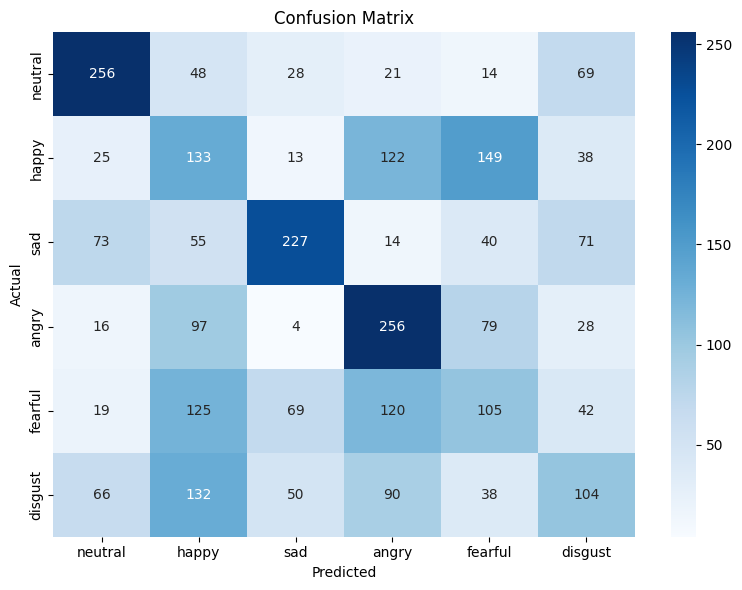

Epoch 1/100 - train_loss: 22.5939 - val_loss: 10.3537 - val_auc: 0.6883 - val_top3: 0.6845 - val_acc: 0.2840
✅ Saved best model: 0.2840
Epoch 2/100 - train_loss: 10.3612 - val_loss: 5.6994 - val_auc: 0.6801 - val_top3: 0.7030 - val_acc: 0.3245
✅ Saved best model: 0.3245
Epoch 3/100 - train_loss: 5.7609 - val_loss: 4.5279 - val_auc: 0.6762 - val_top3: 0.7061 - val_acc: 0.3031
Epoch 4/100 - train_loss: 4.2260 - val_loss: 3.7487 - val_auc: 0.6780 - val_top3: 0.7054 - val_acc: 0.2904
Epoch 5/100 - train_loss: 4.1292 - val_loss: 4.4427 - val_auc: 0.6852 - val_top3: 0.7148 - val_acc: 0.3106
Epoch 6/100 - train_loss: 3.7470 - val_loss: 3.8006 - val_auc: 0.6726 - val_top3: 0.7081 - val_acc: 0.2760
Epoch 7/100 - train_loss: 3.5604 - val_loss: 4.6303 - val_auc: 0.6562 - val_top3: 0.6532 - val_acc: 0.2509
Epoch 8/100 - train_loss: 3.2433 - val_loss: 3.8669 - val_auc: 0.6887 - val_top3: 0.7352 - val_acc: 0.3308
✅ Saved best model: 0.3308
Epoch 9/100 - train_loss: 3.3392 - val_loss: 3.7810 - val_au

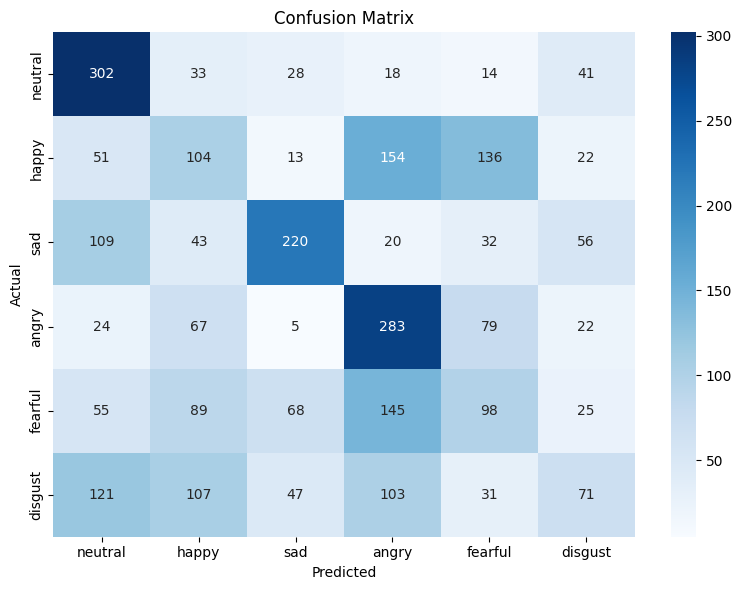

Epoch 1/100 - train_loss: 20.4856 - val_loss: 9.3922 - val_auc: 0.6889 - val_top3: 0.7199 - val_acc: 0.3069
✅ Saved best model: 0.3069
Epoch 2/100 - train_loss: 9.0753 - val_loss: 6.8919 - val_auc: 0.6870 - val_top3: 0.7070 - val_acc: 0.3308
✅ Saved best model: 0.3308
Epoch 3/100 - train_loss: 5.5780 - val_loss: 4.2198 - val_auc: 0.6741 - val_top3: 0.7124 - val_acc: 0.2999
Epoch 4/100 - train_loss: 3.8253 - val_loss: 4.1897 - val_auc: 0.6608 - val_top3: 0.6580 - val_acc: 0.2765
Epoch 5/100 - train_loss: 4.3472 - val_loss: 5.5233 - val_auc: 0.6784 - val_top3: 0.6716 - val_acc: 0.2856
Epoch 6/100 - train_loss: 3.9849 - val_loss: 5.2339 - val_auc: 0.6791 - val_top3: 0.6818 - val_acc: 0.2648
Epoch 7/100 - train_loss: 3.6714 - val_loss: 3.2854 - val_auc: 0.6511 - val_top3: 0.6706 - val_acc: 0.2712
Epoch 8/100 - train_loss: 3.4436 - val_loss: 4.3691 - val_auc: 0.6651 - val_top3: 0.6298 - val_acc: 0.2419
Epoch 9/100 - train_loss: 3.3271 - val_loss: 3.8658 - val_auc: 0.6743 - val_top3: 0.6628 

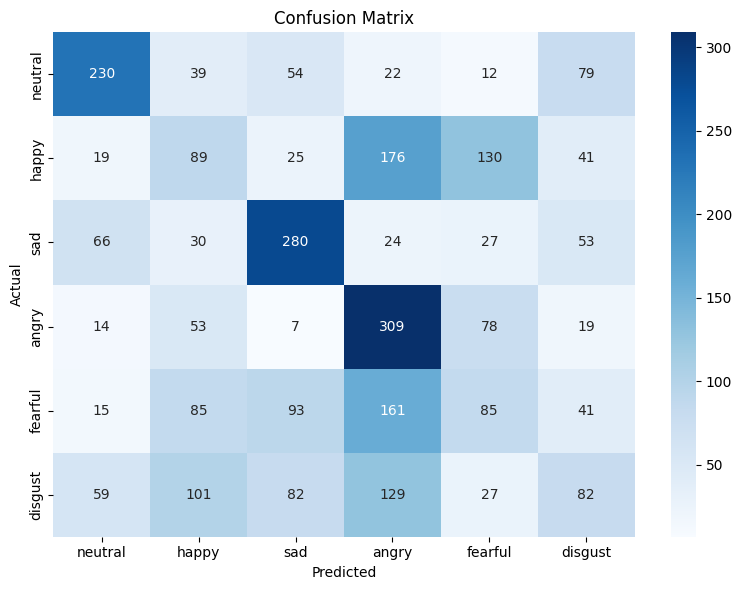

Epoch 1/100 - train_loss: 22.1627 - val_loss: 8.7597 - val_auc: 0.6836 - val_top3: 0.7314 - val_acc: 0.3207
✅ Saved best model: 0.3207
Epoch 2/100 - train_loss: 9.2452 - val_loss: 5.9546 - val_auc: 0.6730 - val_top3: 0.7104 - val_acc: 0.3181
Epoch 3/100 - train_loss: 5.2254 - val_loss: 4.0757 - val_auc: 0.6683 - val_top3: 0.7035 - val_acc: 0.2888
Epoch 4/100 - train_loss: 4.3324 - val_loss: 3.9474 - val_auc: 0.6861 - val_top3: 0.6665 - val_acc: 0.2888
Epoch 5/100 - train_loss: 3.6817 - val_loss: 3.2324 - val_auc: 0.6863 - val_top3: 0.7107 - val_acc: 0.3383
✅ Saved best model: 0.3383
Epoch 6/100 - train_loss: 5.0106 - val_loss: 5.4543 - val_auc: 0.6756 - val_top3: 0.7070 - val_acc: 0.3277
Epoch 7/100 - train_loss: 4.0262 - val_loss: 3.3817 - val_auc: 0.6844 - val_top3: 0.6971 - val_acc: 0.3085
Epoch 8/100 - train_loss: 3.4925 - val_loss: 4.7313 - val_auc: 0.6829 - val_top3: 0.6482 - val_acc: 0.2957
Epoch 9/100 - train_loss: 3.2994 - val_loss: 3.2324 - val_auc: 0.6931 - val_top3: 0.7014 

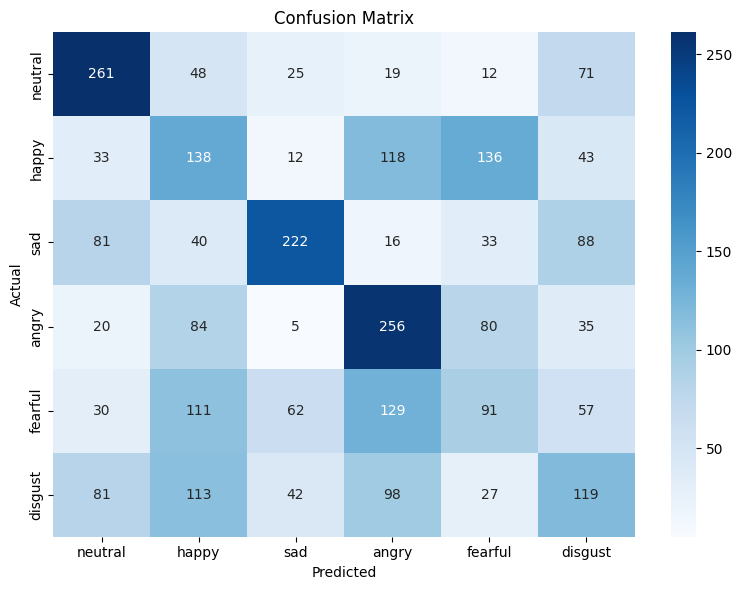

Epoch 1/100 - train_loss: 21.5419 - val_loss: 8.8205 - val_auc: 0.6820 - val_top3: 0.7087 - val_acc: 0.3133
✅ Saved best model: 0.3133
Epoch 2/100 - train_loss: 9.0815 - val_loss: 5.9469 - val_auc: 0.7019 - val_top3: 0.7063 - val_acc: 0.2850
Epoch 3/100 - train_loss: 5.4202 - val_loss: 4.1450 - val_auc: 0.7065 - val_top3: 0.7310 - val_acc: 0.3431
✅ Saved best model: 0.3431
Epoch 4/100 - train_loss: 4.6126 - val_loss: 5.4580 - val_auc: 0.6718 - val_top3: 0.6602 - val_acc: 0.3175
Epoch 5/100 - train_loss: 4.4844 - val_loss: 3.7750 - val_auc: 0.6874 - val_top3: 0.7164 - val_acc: 0.2957
Epoch 6/100 - train_loss: 3.5351 - val_loss: 3.5862 - val_auc: 0.6947 - val_top3: 0.6645 - val_acc: 0.3324
Epoch 7/100 - train_loss: 3.6637 - val_loss: 3.9960 - val_auc: 0.6790 - val_top3: 0.7206 - val_acc: 0.3436
Epoch 8/100 - train_loss: 3.8455 - val_loss: 5.4674 - val_auc: 0.6252 - val_top3: 0.6278 - val_acc: 0.2808
Epoch 9/100 - train_loss: 4.0037 - val_loss: 4.5392 - val_auc: 0.6462 - val_top3: 0.6347 

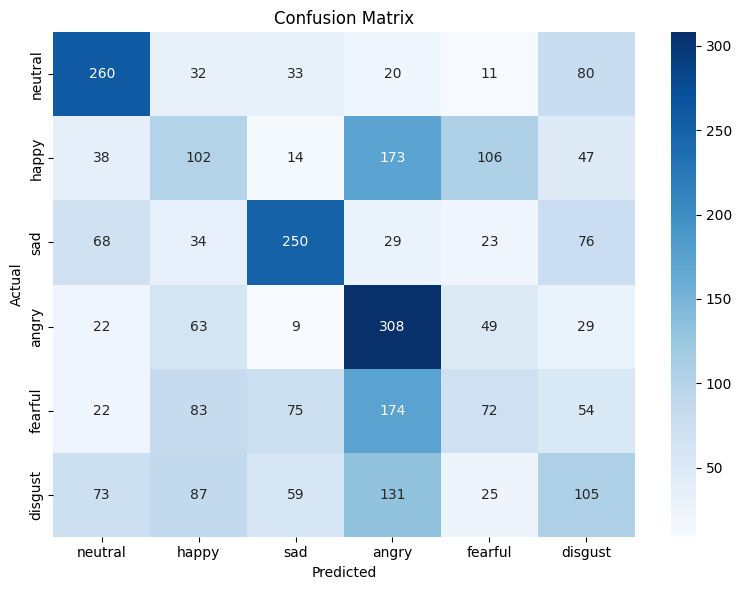

Epoch 1/100 - train_loss: 1.7259 - val_loss: 1.6408 - val_auc: 0.6850 - val_top3: 0.7309 - val_acc: 0.3287
✅ Saved best model: 0.3287
Epoch 2/100 - train_loss: 1.6352 - val_loss: 1.6015 - val_auc: 0.6917 - val_top3: 0.7308 - val_acc: 0.3261
✅ Saved best model: 0.3261
Epoch 3/100 - train_loss: 1.5851 - val_loss: 1.5643 - val_auc: 0.7081 - val_top3: 0.7522 - val_acc: 0.3522
✅ Saved best model: 0.3522
Epoch 4/100 - train_loss: 1.5469 - val_loss: 1.5405 - val_auc: 0.7169 - val_top3: 0.7694 - val_acc: 0.3490
✅ Saved best model: 0.3490
Epoch 5/100 - train_loss: 1.5250 - val_loss: 1.5058 - val_auc: 0.7317 - val_top3: 0.7851 - val_acc: 0.3729
✅ Saved best model: 0.3729
Epoch 6/100 - train_loss: 1.4866 - val_loss: 1.4945 - val_auc: 0.7376 - val_top3: 0.7821 - val_acc: 0.3665
Epoch 7/100 - train_loss: 1.4795 - val_loss: 1.5181 - val_auc: 0.7269 - val_top3: 0.7471 - val_acc: 0.3495
Epoch 8/100 - train_loss: 1.4590 - val_loss: 1.4882 - val_auc: 0.7377 - val_top3: 0.7776 - val_acc: 0.3825
✅ Saved b

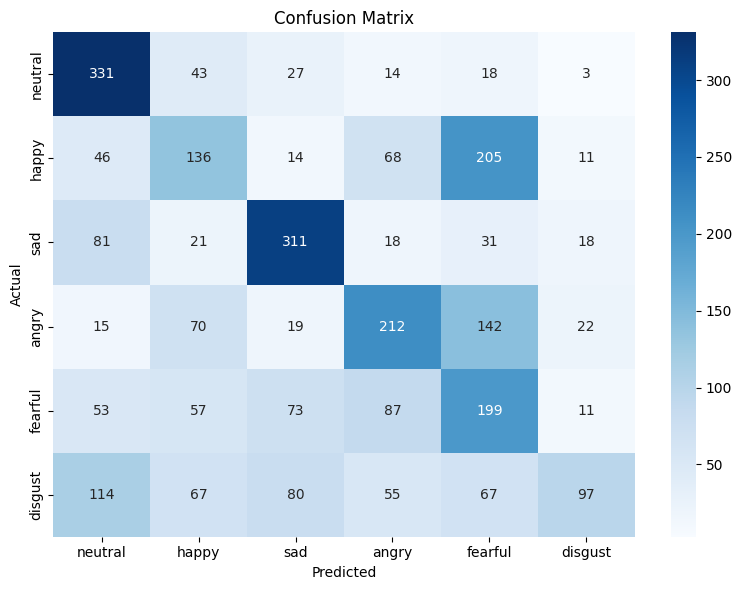

Epoch 1/100 - train_loss: 1.7313 - val_loss: 1.6293 - val_auc: 0.6798 - val_top3: 0.7127 - val_acc: 0.3063
✅ Saved best model: 0.3063
Epoch 2/100 - train_loss: 1.6252 - val_loss: 1.5930 - val_auc: 0.6981 - val_top3: 0.7472 - val_acc: 0.3229
✅ Saved best model: 0.3229
Epoch 3/100 - train_loss: 1.5792 - val_loss: 1.5632 - val_auc: 0.7111 - val_top3: 0.7709 - val_acc: 0.3538
✅ Saved best model: 0.3538
Epoch 4/100 - train_loss: 1.5587 - val_loss: 1.5383 - val_auc: 0.7254 - val_top3: 0.7853 - val_acc: 0.3601
✅ Saved best model: 0.3601
Epoch 5/100 - train_loss: 1.5274 - val_loss: 1.5046 - val_auc: 0.7334 - val_top3: 0.7797 - val_acc: 0.3660
✅ Saved best model: 0.3660
Epoch 6/100 - train_loss: 1.4897 - val_loss: 1.5145 - val_auc: 0.7357 - val_top3: 0.7797 - val_acc: 0.3724
✅ Saved best model: 0.3724
Epoch 7/100 - train_loss: 1.4672 - val_loss: 1.5069 - val_auc: 0.7381 - val_top3: 0.7758 - val_acc: 0.3772
✅ Saved best model: 0.3772
Epoch 8/100 - train_loss: 1.4434 - val_loss: 1.4733 - val_auc:

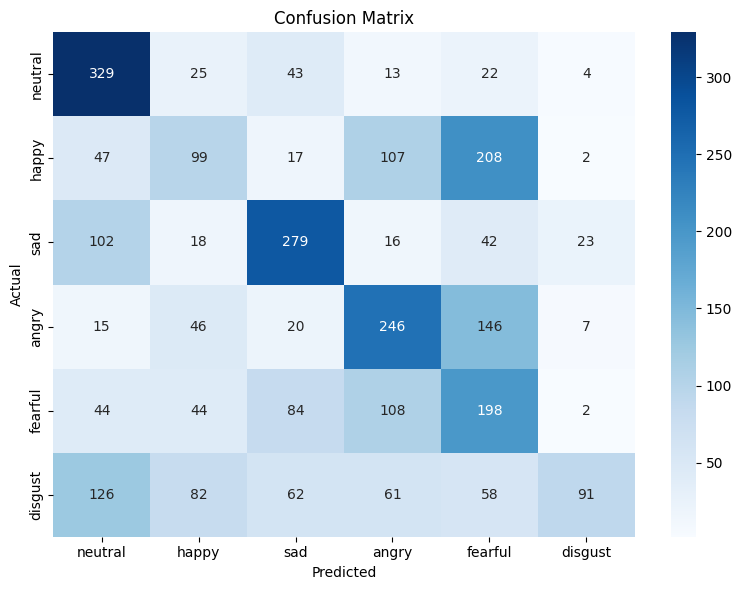

Epoch 1/100 - train_loss: 1.7331 - val_loss: 1.6304 - val_auc: 0.6941 - val_top3: 0.7196 - val_acc: 0.3010
✅ Saved best model: 0.3010
Epoch 2/100 - train_loss: 1.6122 - val_loss: 1.5665 - val_auc: 0.7116 - val_top3: 0.7744 - val_acc: 0.3452
✅ Saved best model: 0.3452
Epoch 3/100 - train_loss: 1.5841 - val_loss: 1.5268 - val_auc: 0.7207 - val_top3: 0.7810 - val_acc: 0.3484
✅ Saved best model: 0.3484
Epoch 4/100 - train_loss: 1.5428 - val_loss: 1.5133 - val_auc: 0.7315 - val_top3: 0.7763 - val_acc: 0.3617
✅ Saved best model: 0.3617
Epoch 5/100 - train_loss: 1.5211 - val_loss: 1.4910 - val_auc: 0.7358 - val_top3: 0.7915 - val_acc: 0.3633
✅ Saved best model: 0.3633
Epoch 6/100 - train_loss: 1.4995 - val_loss: 1.5029 - val_auc: 0.7369 - val_top3: 0.7696 - val_acc: 0.3484
Epoch 7/100 - train_loss: 1.4724 - val_loss: 1.4825 - val_auc: 0.7317 - val_top3: 0.7897 - val_acc: 0.3713
✅ Saved best model: 0.3713
Epoch 8/100 - train_loss: 1.4469 - val_loss: 1.4698 - val_auc: 0.7416 - val_top3: 0.7765 

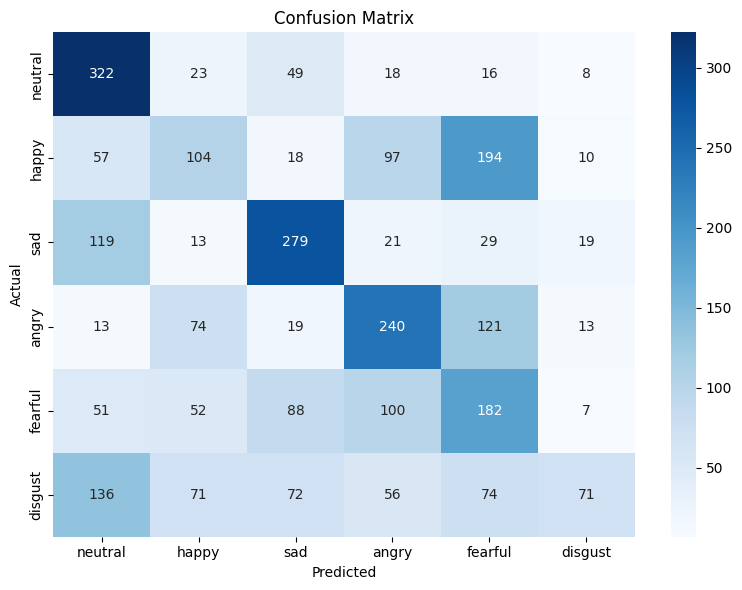

Epoch 1/100 - train_loss: 1.7350 - val_loss: 1.6502 - val_auc: 0.6752 - val_top3: 0.7194 - val_acc: 0.3234
✅ Saved best model: 0.3234
Epoch 2/100 - train_loss: 1.6337 - val_loss: 1.6202 - val_auc: 0.6910 - val_top3: 0.7415 - val_acc: 0.3410
✅ Saved best model: 0.3410
Epoch 3/100 - train_loss: 1.5766 - val_loss: 1.5472 - val_auc: 0.7034 - val_top3: 0.7641 - val_acc: 0.3463
✅ Saved best model: 0.3463
Epoch 4/100 - train_loss: 1.5420 - val_loss: 1.5352 - val_auc: 0.7159 - val_top3: 0.7776 - val_acc: 0.3596
✅ Saved best model: 0.3596
Epoch 5/100 - train_loss: 1.5147 - val_loss: 1.5305 - val_auc: 0.7174 - val_top3: 0.7686 - val_acc: 0.3639
✅ Saved best model: 0.3639
Epoch 6/100 - train_loss: 1.4827 - val_loss: 1.5006 - val_auc: 0.7184 - val_top3: 0.7787 - val_acc: 0.3708
✅ Saved best model: 0.3708
Epoch 7/100 - train_loss: 1.4598 - val_loss: 1.4883 - val_auc: 0.7309 - val_top3: 0.7788 - val_acc: 0.3697
✅ Saved best model: 0.3697
Epoch 8/100 - train_loss: 1.4385 - val_loss: 1.4953 - val_auc:

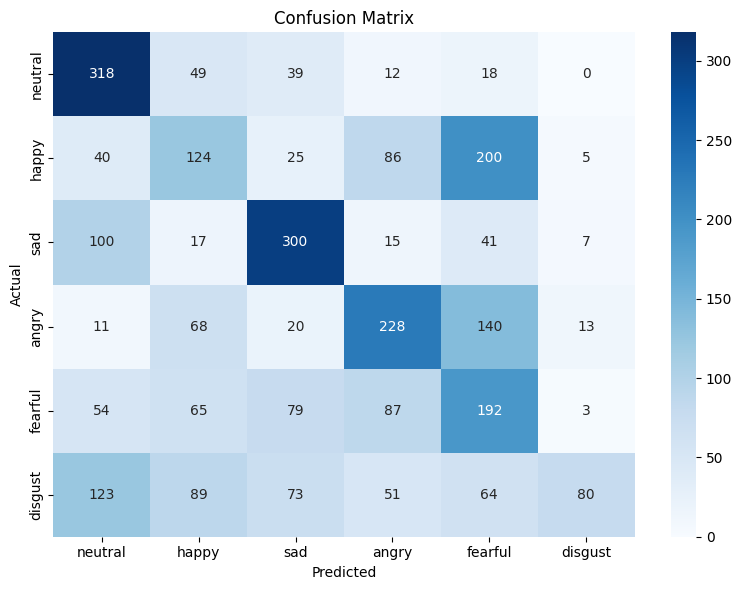

Epoch 1/100 - train_loss: 1.7512 - val_loss: 1.6607 - val_auc: 0.6640 - val_top3: 0.7170 - val_acc: 0.3079
✅ Saved best model: 0.3079
Epoch 2/100 - train_loss: 1.6473 - val_loss: 1.6202 - val_auc: 0.6885 - val_top3: 0.7406 - val_acc: 0.3282
✅ Saved best model: 0.3282
Epoch 3/100 - train_loss: 1.6004 - val_loss: 1.5802 - val_auc: 0.6984 - val_top3: 0.7517 - val_acc: 0.3511
✅ Saved best model: 0.3511
Epoch 4/100 - train_loss: 1.5544 - val_loss: 1.5453 - val_auc: 0.7099 - val_top3: 0.7687 - val_acc: 0.3559
✅ Saved best model: 0.3559
Epoch 5/100 - train_loss: 1.5310 - val_loss: 1.5297 - val_auc: 0.7151 - val_top3: 0.7664 - val_acc: 0.3586
✅ Saved best model: 0.3586
Epoch 6/100 - train_loss: 1.5056 - val_loss: 1.5269 - val_auc: 0.7207 - val_top3: 0.7640 - val_acc: 0.3538
✅ Saved best model: 0.3538
Epoch 7/100 - train_loss: 1.4983 - val_loss: 1.5156 - val_auc: 0.7280 - val_top3: 0.7696 - val_acc: 0.3586
✅ Saved best model: 0.3586
Epoch 8/100 - train_loss: 1.4705 - val_loss: 1.5122 - val_auc:

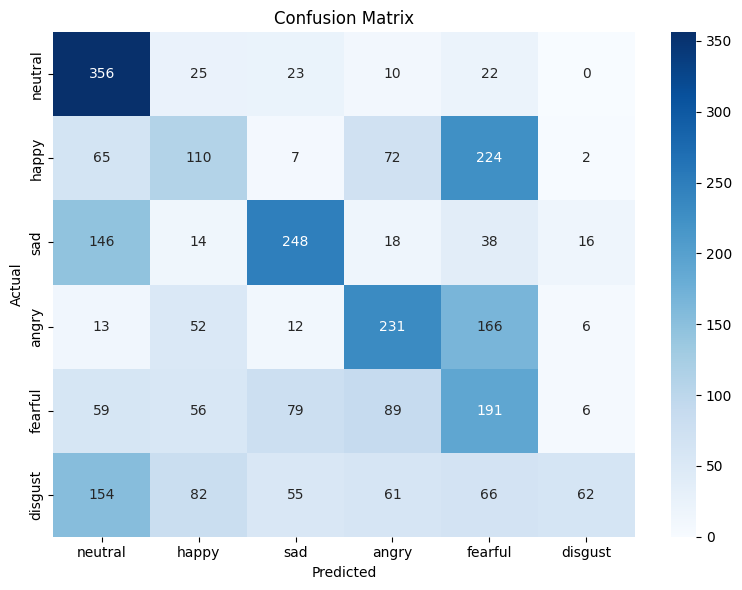

PI-Linear: {'auc': (0.7335885882377624, 0.0014627164435951042), 'acc': (0.3820874452590942, 0.0030699376528869897), 'top3_acc': (0.789164137840271, 0.00876937384658858), 'macro_f1': (0.37267143600813246, 0.008917567460504651)}
PI-MLP: {'auc': (0.7900070309638977, 0.00642216535157761), 'acc': (0.434837806224823, 0.012980619707849625), 'top3_acc': (0.8290723919868469, 0.004033766660454138), 'macro_f1': (0.41868047770587935, 0.016399188696793982)}


In [19]:

pi_linear_results = [
    run_topo_noncNN(
        seed=s,
        model_ctor=lambda: PILinear(in_shape=(6,32,32), num_classes=6),
        model_name="pi_linear",
        batch_size=256,
        lr=1e-3,
        num_epochs=100
    ) for s in SEEDS
]

pi_mlp_results = [
    run_topo_noncNN(
        seed=s,
        model_ctor=lambda: PIMLP(in_shape=(6,32,32), num_classes=6, hidden=(512, 256,64,64)),
        model_name="pi_mlp",
        batch_size=256,
        lr=1e-3,
        num_epochs=100
    ) for s in SEEDS
]

print("PI-Linear:", summarize_with_f1(pi_linear_results))
print("PI-MLP:", summarize_with_f1(pi_mlp_results))

In [20]:
summary = summarize_with_f1(pi_linear_results)
ds_summary = summarize_acc_per_dataset(pi_linear_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.7336 ± 0.0015
Macro-F1: 0.3727 ± 0.0089
Acc: 0.3821 ± 0.0031
Top-3: 0.7892 ± 0.0088
cremad: 0.4101 ± 0.0118
radvess: 0.2610 ± 0.0088
savee: 0.2324 ± 0.0239
tess: 0.3977 ± 0.0132


In [21]:
summary = summarize_with_f1(pi_mlp_results)
ds_summary = summarize_acc_per_dataset(pi_mlp_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.7900 ± 0.0064
Macro-F1: 0.4187 ± 0.0164
Acc: 0.4348 ± 0.0130
Top-3: 0.8291 ± 0.0040
cremad: 0.4460 ± 0.0069
radvess: 0.2760 ± 0.0046
savee: 0.3410 ± 0.0412
tess: 0.4725 ± 0.0257



==================== CRNN Seed 0 ====================
Epoch 1/60 - train_loss: 1.7010 - val_loss: 2.1793 - val_auc: 0.6383 - val_top3: 0.5068 - val_acc: 0.1673
✅ Saved best model: 0.1673
Epoch 2/60 - train_loss: 1.5192 - val_loss: 1.5530 - val_auc: 0.7226 - val_top3: 0.7647 - val_acc: 0.3522
✅ Saved best model: 0.3522
Epoch 3/60 - train_loss: 1.4404 - val_loss: 1.5292 - val_auc: 0.7297 - val_top3: 0.7629 - val_acc: 0.3596
✅ Saved best model: 0.3596
Epoch 4/60 - train_loss: 1.3737 - val_loss: 1.4911 - val_auc: 0.7450 - val_top3: 0.7813 - val_acc: 0.3831
✅ Saved best model: 0.3831
Epoch 5/60 - train_loss: 1.3345 - val_loss: 1.9609 - val_auc: 0.6959 - val_top3: 0.7240 - val_acc: 0.3495
Epoch 6/60 - train_loss: 1.2816 - val_loss: 1.4919 - val_auc: 0.7506 - val_top3: 0.7951 - val_acc: 0.3953
✅ Saved best model: 0.3953
Epoch 7/60 - train_loss: 1.2409 - val_loss: 1.5348 - val_auc: 0.7547 - val_top3: 0.7919 - val_acc: 0.4033
✅ Saved best model: 0.4033
Epoch 8/60 - train_loss: 1.1869 - val_los

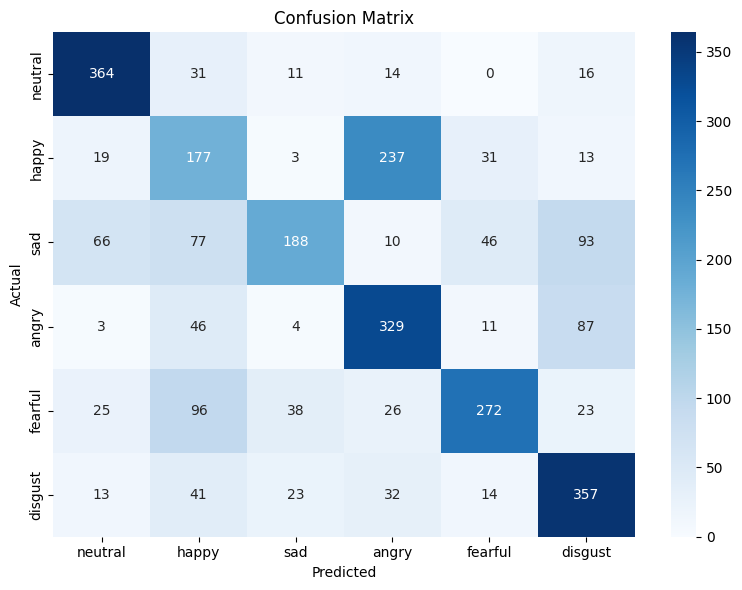


==================== CRNN Seed 1 ====================
Epoch 1/60 - train_loss: 1.7063 - val_loss: 1.9263 - val_auc: 0.6421 - val_top3: 0.5582 - val_acc: 0.1875
✅ Saved best model: 0.1875
Epoch 2/60 - train_loss: 1.5207 - val_loss: 1.8069 - val_auc: 0.6721 - val_top3: 0.6465 - val_acc: 0.2653
✅ Saved best model: 0.2653
Epoch 3/60 - train_loss: 1.4418 - val_loss: 1.5850 - val_auc: 0.7172 - val_top3: 0.7297 - val_acc: 0.3367
✅ Saved best model: 0.3367
Epoch 4/60 - train_loss: 1.3932 - val_loss: 1.4865 - val_auc: 0.7432 - val_top3: 0.7787 - val_acc: 0.4076
✅ Saved best model: 0.4076
Epoch 5/60 - train_loss: 1.3765 - val_loss: 1.4941 - val_auc: 0.7452 - val_top3: 0.7870 - val_acc: 0.3958
Epoch 6/60 - train_loss: 1.3116 - val_loss: 1.7498 - val_auc: 0.7108 - val_top3: 0.6852 - val_acc: 0.2920
Epoch 7/60 - train_loss: 1.2650 - val_loss: 2.0850 - val_auc: 0.6736 - val_top3: 0.6554 - val_acc: 0.2600
Epoch 8/60 - train_loss: 1.2377 - val_loss: 1.4241 - val_auc: 0.7714 - val_top3: 0.8255 - val_a

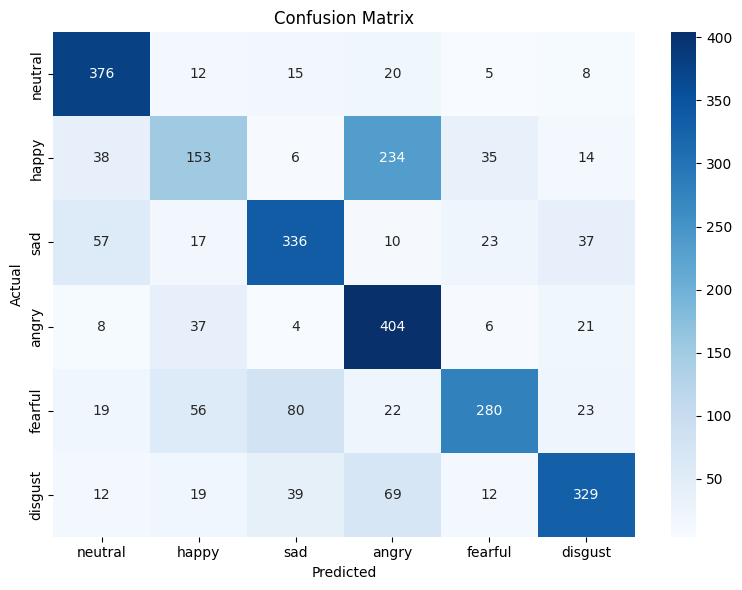


==================== CRNN Seed 2 ====================
Epoch 1/60 - train_loss: 1.6942 - val_loss: 1.7458 - val_auc: 0.6823 - val_top3: 0.6443 - val_acc: 0.2451
✅ Saved best model: 0.2451


In [ ]:
SEEDS = [0, 1, 2, 3, 4]

# ---- CRNN ----
crnn_results = []
for s in SEEDS:
    print(f"\n{'='*20} CRNN Seed {s} {'='*20}")
    crnn_results.append(
        run_mel_baseline(
            seed=s,
            model_ctor=lambda: CRNNSpectrogram(num_classes=6),
            model_tag="crnn_mel",
            lr=1e-3,
            batch_size=256,
            epochs=100,
        )
    )

crnn_summary = summarize_with_f1(crnn_results)
print("CRNN summary:", crnn_summary)



==================== ResNet18 Seed 0 ====================
Epoch 1/60 - train_loss: 1.3047 - val_loss: 2.4855 - val_auc: 0.7549 - val_top3: 0.7594 - val_acc: 0.3774
✅ Saved best model: 0.3774
Epoch 2/60 - train_loss: 0.9169 - val_loss: 1.9615 - val_auc: 0.7941 - val_top3: 0.7362 - val_acc: 0.3774
Epoch 3/60 - train_loss: 0.8052 - val_loss: 1.5838 - val_auc: 0.8303 - val_top3: 0.8521 - val_acc: 0.4746
✅ Saved best model: 0.4746
Epoch 4/60 - train_loss: 0.7019 - val_loss: 1.8595 - val_auc: 0.8369 - val_top3: 0.8066 - val_acc: 0.4028
Epoch 5/60 - train_loss: 0.6184 - val_loss: 3.8440 - val_auc: 0.7746 - val_top3: 0.7335 - val_acc: 0.3460
Epoch 6/60 - train_loss: 0.5897 - val_loss: 1.9382 - val_auc: 0.8231 - val_top3: 0.7511 - val_acc: 0.3635
Epoch 7/60 - train_loss: 0.4824 - val_loss: 2.4668 - val_auc: 0.8093 - val_top3: 0.8254 - val_acc: 0.4565
Epoch 8/60 - train_loss: 0.3851 - val_loss: 1.6328 - val_auc: 0.8502 - val_top3: 0.8930 - val_acc: 0.5290
✅ Saved best model: 0.5290
Epoch 9/60 -

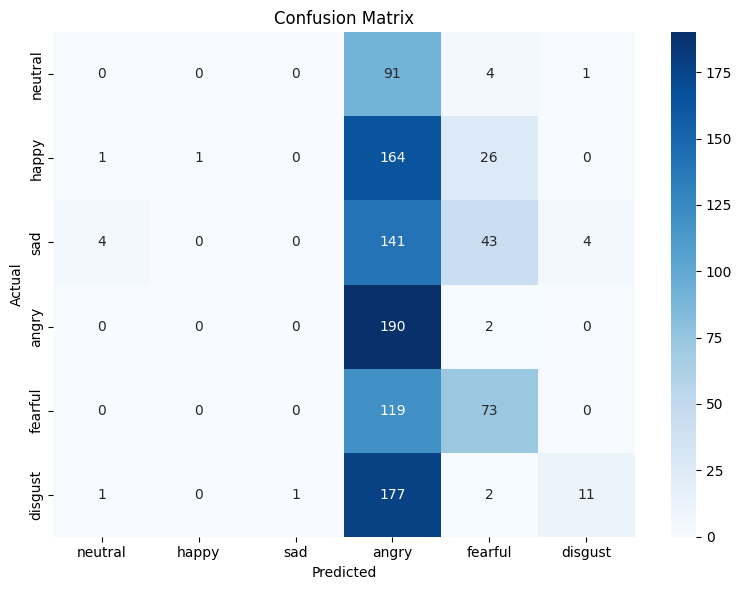


==================== ResNet18 Seed 1 ====================
Epoch 1/60 - train_loss: 1.2960 - val_loss: 2.9778 - val_auc: 0.7306 - val_top3: 0.6947 - val_acc: 0.3207
✅ Saved best model: 0.3207
Epoch 2/60 - train_loss: 0.9105 - val_loss: 1.3337 - val_auc: 0.8346 - val_top3: 0.8672 - val_acc: 0.4807
✅ Saved best model: 0.4807
Epoch 3/60 - train_loss: 0.7889 - val_loss: 2.5868 - val_auc: 0.7515 - val_top3: 0.7240 - val_acc: 0.2935
Epoch 4/60 - train_loss: 0.6839 - val_loss: 1.7835 - val_auc: 0.8227 - val_top3: 0.8219 - val_acc: 0.4378
Epoch 5/60 - train_loss: 0.6170 - val_loss: 2.0909 - val_auc: 0.8221 - val_top3: 0.8314 - val_acc: 0.4668
Epoch 6/60 - train_loss: 0.5029 - val_loss: 1.9290 - val_auc: 0.8282 - val_top3: 0.8353 - val_acc: 0.4505
Epoch 7/60 - train_loss: 0.4334 - val_loss: 1.7653 - val_auc: 0.8529 - val_top3: 0.8729 - val_acc: 0.5296
✅ Saved best model: 0.5296
Epoch 8/60 - train_loss: 0.3162 - val_loss: 5.2726 - val_auc: 0.7531 - val_top3: 0.7496 - val_acc: 0.3122
Epoch 9/60 -

In [ ]:
# ---- ResNet18 ----
resnet_results = []
for s in SEEDS:
    print(f"\n{'='*20} ResNet18 Seed {s} {'='*20}")
    resnet_results.append(
        run_mel_baseline(
            seed=s,
            model_ctor=lambda: ResNet18Spectrogram(num_classes=6, pretrained=False),
            model_tag="resnet18_mel",
            lr=1e-3,
            batch_size=256,
            epochs=100,
        )
    )

resnet_summary = summarize_with_f1(resnet_results)
print("ResNet18 summary:", resnet_summary)

In [ ]:
summary = summarize_with_f1(resnet_results)
ds_summary = summarize_acc_per_dataset(resnet_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8679 ± 0.0089
Macro-F1: 0.5727 ± 0.0150
Acc: 0.5785 ± 0.0147
Top-3: 0.8750 ± 0.0135
cremad: 0.6064 ± 0.0077
radvess: 0.5688 ± 0.0178
savee: 0.3638 ± 0.0671
tess: 0.5713 ± 0.0336


In [ ]:
summary = summarize_with_f1(crnn_results)
ds_summary = summarize_acc_per_dataset(crnn_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8471 ± 0.0118
Macro-F1: 0.5462 ± 0.0103
Acc: 0.5593 ± 0.0149
Top-3: 0.9142 ± 0.0191
cremad: 0.5887 ± 0.0136
radvess: 0.5578 ± 0.0346
savee: 0.4038 ± 0.0730
tess: 0.5433 ± 0.0236


In [36]:
SEEDS = [0, 1, 2, 3, 4]

# ---- ResNet18 ----
fusion_crnn_results = []
for s in SEEDS:
    print(f"\n{'='*20} FusionCrnn Seed {s} {'='*20}")
    fusion_crnn_results.append(
        run_fusion(
            seed=s,
            model = FusionCRNNTopo(num_classes=6, topo_dim=128, rnn_hidden=128).to(device),
            model_name="fusion_crnn",
            lr=1e-3,
            batch_size=256,
            num_epochs=100,
        )
    )

resnet_summary = summarize_with_f1(fusion_crnn_results)
print("FusionCrnn summary:", resnet_summary)


==================== FusionCrnn Seed 0 ====================


Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
               ^^^^^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^^
^^^^^  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
            

RuntimeError: DataLoader worker (pid(s) 45645) exited unexpectedly

In [ ]:
summary = summarize_with_f1(fusion_crnn_results)
ds_summary = summarize_acc_per_dataset(fusion_crnn_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8827 ± 0.0123
Macro-F1: 0.6200 ± 0.0190
Acc: 0.6227 ± 0.0159
Top-3: 0.9091 ± 0.0241
cremad: 0.5928 ± 0.0052
radvess: 0.5338 ± 0.0391
savee: 0.3143 ± 0.0490
tess: 0.7030 ± 0.0385


In [29]:
# ---- ResNet18 ----
fusion_resnet_results = []
for s in SEEDS:
    print(f"\n{'='*20} FusionCrnn Seed {s} {'='*20}")
    fusion_resnet_results.append(
        run_fusion(
            seed=s,
            model = FusionResNet18Topo(num_classes=6, topo_dim=128, pretrained=False).to(device),
            model_name="fusion_resnet",
            lr=1e-3,
            batch_size=256
        )
    )

resnet_summary = summarize_with_f1(fusion_resnet_results)
print("Fusionresnet summary:", resnet_summary)


==================== FusionCrnn Seed 0 ====================


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MelTopoDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/pyth

RuntimeError: DataLoader worker (pid(s) 44804) exited unexpectedly

In [ ]:
summary = summarize_with_f1(fusion_resnet_results)
ds_summary = summarize_acc_per_dataset(fusion_resnet_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

AUC: 0.8499 ± 0.0205
Macro-F1: 0.5433 ± 0.0229
Acc: 0.5506 ± 0.0259
Top-3: 0.8774 ± 0.0379
cremad: 0.6021 ± 0.0176
radvess: 0.5539 ± 0.0363
savee: 0.2971 ± 0.0561
tess: 0.5195 ± 0.0486


In [ ]:
import torch, torchaudio
import torch.nn as nn

# device = "cuda" if torch.cuda.is_available() else "cpu"

bundle = torchaudio.pipelines.WAV2VEC2_BASE
ssl_model = bundle.get_model().to(device)
ssl_model.eval()
for p in ssl_model.parameters():
    p.requires_grad = False

TARGET_SR = bundle.sample_rate  # usually 16000


In [ ]:
device

device(type='mps')

In [ ]:
class W2V2Baseline(nn.Module):
    def __init__(self, ssl_model, num_classes=6, proj_dim=256):
        super().__init__()
        self.ssl = ssl_model
        # wav2vec2 outputs [B, T', C]; C is encoder_embed_dim
        C = self.ssl.encoder_embed_dim
        self.head = nn.Sequential(
            nn.Linear(C, proj_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(proj_dim, num_classes),
        )

    def forward(self, wav):  # wav: (B, T)
        with torch.no_grad():
            feats, _ = self.ssl.extract_features(wav)  # list of layer features
            h = feats[-1]                               # (B, T', C)
        emb = h.mean(dim=1)                             # (B, C)
        return self.head(emb)

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio

# device = "cuda" if torch.cuda.is_available() else "cpu"

def load_wav(path, target_sr):
    wav, sr = torchaudio.load(path)     # (C, T)
    wav = wav.mean(dim=0)               # mono -> (T,)
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, sr, target_sr)
    wav = wav.to(torch.float32).clamp(-1.0, 1.0)
    return wav

class AudioDataset(Dataset):
    def __init__(self, paths, y_int, names=None, target_sr=16000, max_seconds=None):
        self.paths = list(paths)
        self.y = torch.as_tensor(y_int, dtype=torch.long)
        self.names = None if names is None else list(names)
        self.target_sr = int(target_sr)
        self.max_len = None if max_seconds is None else int(max_seconds * self.target_sr)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        wav = load_wav(self.paths[idx], self.target_sr)
        if self.max_len is not None and wav.numel() > self.max_len:
            wav = wav[:self.max_len]
        if self.names is None:
            return wav, self.y[idx]
        return wav, self.y[idx], self.names[idx]

def collate_pad(batch):
    # supports (wav, y) or (wav, y, name)
    if len(batch[0]) == 2:
        wavs, ys = zip(*batch)
        names = None
    else:
        wavs, ys, names = zip(*batch)

    wavs_pad = torch.nn.utils.rnn.pad_sequence(wavs, batch_first=True)  # (B, T_max)
    ys = torch.stack(list(ys))

    if names is None:
        return wavs_pad, ys
    return wavs_pad, ys, list(names)


import torch
import torch.nn as nn

class SSLMeanPoolBaseline(nn.Module):
    def __init__(self, ssl_model, num_classes=6, proj_dim=256, dropout=0.2, sample_rate=16000):
        super().__init__()
        self.ssl = ssl_model

        # Determine SSL device (mps/cuda/cpu) robustly
        ssl_device = next(self.ssl.parameters()).device

        # Infer feature dim C using a dummy waveform on the SAME device as ssl_model
        with torch.no_grad():
            dummy = torch.zeros(1, sample_rate, device=ssl_device)  # 1 second
            feats, _ = self.ssl.extract_features(dummy)
            C = feats[-1].shape[-1]

        self.head = nn.Sequential(
            nn.Linear(C, proj_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(proj_dim, num_classes),
        )

    def forward(self, wav):  # wav: (B, T) on device from train_model
        ssl_device = next(self.ssl.parameters()).device
        wav = wav.to(ssl_device)

        with torch.no_grad():
            feats, _ = self.ssl.extract_features(wav)
            h = feats[-1]          # (B, T', C)
        emb = h.mean(dim=1)        # (B, C)

        # head lives on the main model device; emb is on ssl_device, so move to head device
        emb = emb.to(next(self.head.parameters()).device)
        return self.head(emb)


In [ ]:
def run_wavlm_experiment(seed: int, freeze_encoder=True, lr=1e-3, num_epochs=30, max_seconds=None):
    set_seed(seed)

    target_sr = 16000
    y_int_all = np.argmax(myY, axis=1).astype(np.int64)  # if myY is one-hot
# otherwise: y_int_all = np.asarray(myY).astype(np.int64)


    # train_ds = AudioPathDataset(
    #     paths=myPaths[train_idx],
    #     labels=myY[train_idx],
    #     dataset_names=None,
    #     target_sr=target_sr,
    #     max_seconds=max_seconds
    # )
    # val_ds = AudioPathDataset(
    #     paths=myPaths[val_idx],
    #     labels=myY[val_idx],
    #     dataset_names=None,
    #     target_sr=target_sr,
    #     max_seconds=max_seconds
    # )
    # test_ds = AudioPathDataset(
    #     paths=myPaths[test_idx],
    #     labels=myY[test_idx],
    #     dataset_names=myDatasets[test_idx],
    #     target_sr=target_sr,
    #     max_seconds=max_seconds
    # )

    g = torch.Generator()
    g.manual_seed(seed)

    train_ds = AudioDataset(myPaths[train_idx], y_int_all[train_idx], target_sr=TARGET_SR)
    val_ds   = AudioDataset(myPaths[val_idx],   y_int_all[val_idx],   target_sr=TARGET_SR)
    test_ds  = AudioDataset(myPaths[test_idx],  y_int_all[test_idx],  names=myDatasets[test_idx], target_sr=TARGET_SR)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0, collate_fn=collate_pad)
    val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_pad)
    test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_pad)


    model = SSLMeanPoolBaseline(ssl_model, num_classes=6).to(device)

    model, hist = train_model(
        model,
        train_loader,
        val_loader,
        num_epochs=20,
        lr=1e-3,
        model_name="ssl_w2v2_base",
        device=device
    )

    results = evaluate_model(model, test_loader, device=device)
    results

    return results


In [ ]:
device

device(type='mps')

In [ ]:
# ---- ResNet18 ----
wav_results = []
for s in SEEDS:
    print(f"\n{'='*20} ResNet18 Seed {s} {'='*20}")
    wav_results.append(
        run_wavlm_experiment(
            seed=s,
            lr=1e-3,
        )
    )

wav_summary = summarize_with_f1(wav_results)
print("Wav summary:", wav_results)


==================== ResNet18 Seed 0 ====================


In [ ]:
summary = summarize_with_f1(wav_results)
ds_summary = summarize_acc_per_dataset(wav_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

In [ ]:


def run_mel_experiment(seed: int):
    set_seed(seed)

    # Datasets
    train_dataset_mel = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset_mel   = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset_mel  = TensorDatasetWithNames(
        X_test_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    # IMPORTANT: seed-controlled shuffling
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_mel = DataLoader(
        train_dataset_mel,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_mel = DataLoader(
        val_dataset_mel,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_mel = DataLoader(
        test_dataset_mel,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init model every seed)
    model_mel = MelSpectrogramCNN().to(device)
    model_mel, history_mel = train_model(
        model_mel,
        train_loader_mel,
        val_loader_mel,
        num_epochs=60,
        model_name=f"model_mel_seed{seed}",
        device=device
    )

    # Evaluate
    results_mel = evaluate_model(
        model_mel,
        test_loader_mel,
        f"best_model_mel_seed{seed}.pth",
        device
    )

    print(results_mel)

    return results_mel



seeds = [0, 1, 2, 3, 4]
all_results = []

for s in seeds:
    print(f"\n{'='*20} Seed {s} {'='*20}")
    all_results.append(run_mel_experiment(s))

In [ ]:
summary = summarize_with_f1(all_results)
ds_summary = summarize_acc_per_dataset(all_results)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

In [ ]:
def run_topo_experiment(seed: int):
    set_seed(seed)

    train_dataset_topo = TensorDataset(X_train2_tensor, y_train_tensor)
    val_dataset_topo   = TensorDataset(X_val2_tensor, y_val_tensor)
    test_dataset_topo  = TensorDatasetWithNames(
        X_test2_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_topo = DataLoader(
        train_dataset_topo,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_topo = DataLoader(
        val_dataset_topo,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_topo = DataLoader(
        test_dataset_topo,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init every seed)
    model_topo = TopologicalCNN().to(device)
    model_topo, history_topo = train_model(
        model_topo,
        train_loader_topo,
        val_loader_topo,
        num_epochs=60,
        lr=1e-4,
        model_name=f"model_topo_seed{seed}",
        device=device
    )

    results_topo = evaluate_model(
        model_topo,
        test_loader_topo,
        f"best_model_topo_seed{seed}.pth",
        device
    )

    return results_topo



seeds = [0, 1, 2, 3, 4]
all_results_topo = []

for s in seeds:
    print(f"\n{'='*20} TOPO Seed {s} {'='*20}")
    all_results_topo.append(run_topo_experiment(s))

In [ ]:
summary = summarize_with_f1(all_results_topo)
ds_summary = summarize_acc_per_dataset(all_results_topo)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

In [ ]:
def run_fusion_experiment(seed: int):
    set_seed(seed)

    # Datasets
    train_dataset_comb = TensorDataset(X_train_tensor, X_train2_tensor, y_train_tensor)
    val_dataset_comb   = TensorDataset(X_val_tensor, X_val2_tensor, y_val_tensor)
    test_dataset_comb  = TensorDatasetWithNamesComb(
        X_test_tensor,
        X_test2_tensor,
        y_test_tensor,
        myDatasets[test_idx]
    )

    # Seed-controlled shuffling
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader_comb = DataLoader(
        train_dataset_comb,
        batch_size=256,
        shuffle=True,
        generator=g,
        num_workers=4,
        pin_memory=True
    )
    val_loader_comb = DataLoader(
        val_dataset_comb,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    test_loader_comb = DataLoader(
        test_dataset_comb,
        batch_size=256,
        shuffle=False
    )

    # Train (re-init every seed)
    model_comb = CombinedFusionModel().to(device)
    model_comb, history_comb = train_model(
        model_comb,
        train_loader_comb,
        val_loader_comb,
        num_epochs=60,
        model_name=f"model_combined_seed{seed}",   # avoid overwrite
        device=device
    )

    # Evaluate (seed-specific checkpoint)
    results_comb = evaluate_model(
        model_comb,
        test_loader_comb,
        f"best_model_combined_seed{seed}.pth",     # ensure train_model saves this
        device
    )

    return results_comb


# ---- Run multiple seeds and summarize ----
seeds = [0, 1, 2, 3, 4]   # N=5
all_results_comb = []

for s in seeds:
    print(f"\n{'='*20} FUSION Seed {s} {'='*20}")
    all_results_comb.append(run_fusion_experiment(s))

In [ ]:
summary = summarize_with_f1(all_results_comb)
ds_summary = summarize_acc_per_dataset(all_results_comb)
print(f"AUC: {summary['auc'][0]:.4f} ± {summary['auc'][1]:.4f}")
print(f"Macro-F1: {summary['macro_f1'][0]:.4f} ± {summary['macro_f1'][1]:.4f}")
print(f"Acc: {summary['acc'][0]:.4f} ± {summary['acc'][1]:.4f}")
print(f"Top-3: {summary['top3_acc'][0]:.4f} ± {summary['top3_acc'][1]:.4f}")
for ds, (mu, sd) in ds_summary.items():
    print(f"{ds}: {mu:.4f} ± {sd:.4f}")

In [ ]:
# Interpretability: Integrated Gradients per Channel
from pathlib import Path

def compute_channel_importance_ig(model, test_loader, device, save_dir="attr_summary"):
    """
    Compute per-channel attribution using Integrated Gradients.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    ig = IntegratedGradients(model)
    model.eval()

    acc_global = None
    count_global = 0

    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        baseline = torch.zeros_like(X_batch)

        # Compute IG
        attr = ig.attribute(X_batch, baselines=baseline, target=y_batch)
        batch_attr = attr.abs().sum(dim=0).detach().cpu()  # (C, H, W)

        acc_global = batch_attr if acc_global is None else acc_global + batch_attr
        count_global += X_batch.size(0)

    mean_attr_global = acc_global / max(count_global, 1)
    C, H, W = mean_attr_global.shape

    # Per-channel importance scores
    per_channel_scores = mean_attr_global.view(C, -1).mean(dim=1).numpy()

    print("\nPer-Channel Importance (Integrated Gradients):")
    channel_names = [
        'Euclidean (H0)',
        'Euclidean (H1)',
        'Temporal (H0)',
        'Temporal (H1)',
        'Wasserstein (H0)',
        'Wasserstein (H1)'
    ]
    for c, (name, score) in enumerate(zip(channel_names, per_channel_scores)):
        print(f"Channel {c} ({name}): {score:.6f}")

    # Save heatmaps
    def save_heat(heat2d, title, path):
        h = (heat2d - heat2d.min()) / (heat2d.max() - heat2d.min() + 1e-8)
        plt.figure(figsize=(4.5, 4))
        plt.imshow(h, cmap="jet")
        plt.title(title)
        plt.axis("off")
        plt.colorbar()
        plt.tight_layout()
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.close()

    for c in range(C):
        heat = mean_attr_global[c].numpy()
        save_heat(heat, f"IG Attribution — {channel_names[c]}",
                  save_dir / f"ig_channel_{c}.png")

    # Bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(C), per_channel_scores)
    plt.xlabel("Channel", fontsize=12)
    plt.ylabel("Mean |IG Attribution|", fontsize=12)
    plt.title("Per-Channel Importance (Integrated Gradients)", fontsize=14)
    plt.xticks(range(C), [f"Ch{c}\n{name}" for c, name in enumerate(channel_names)],
               rotation=45, ha='right', fontsize=9)

    # Color bars by metric type
    colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.savefig(save_dir / "channel_importance_ig.png", dpi=300, bbox_inches='tight')
    plt.show()

    np.save(save_dir / "per_channel_scores_ig.npy", per_channel_scores)
    return per_channel_scores

test_dataset_topo  = TensorDataset(
    X_test2_tensor,
    y_test_tensor
)

test_loader_topo = DataLoader(
    test_dataset_topo,
    batch_size=256,
    shuffle=False
)

model_topo = TopologicalCNN().to(device)
# Run IG analysis on topological
print("\n" + "="*60)
print("Interpretability Analysis: Integrated Gradients")
print("="*60)
model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
channel_scores_ig = compute_channel_importance_ig(model_topo, test_loader_topo, device)

In [ ]:
# Occlusion analysis per channel
def compute_channel_importance_occlusion(model, test_loader, device,
                                         patch_size=8, stride=4,
                                         save_dir="attr_summary"):
    """
    Compute per-channel importance using Occlusion method.
    """
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    occ = Occlusion(model)
    model.eval()

    # Sample a few examples for visualization
    X_sample, y_sample = next(iter(test_loader))
    X_sample = X_sample[:5].to(device)  # First 5 samples
    y_sample = y_sample[:5].to(device)

    channel_names = [
        'Euclidean (clean)',
        'Euclidean (noise)',
        'Temporal (clean)',
        'Temporal (noise)',
        'Wasserstein (clean)',
        'Wasserstein (noise)'
    ]

    C = X_sample.shape[1]
    attr_per_channel = []

    for sample_idx in range(len(X_sample)):
        x = X_sample[sample_idx:sample_idx+1]
        target = int(y_sample[sample_idx])

        for c in range(C):
            attr = occ.attribute(
                x,
                target=target,
                sliding_window_shapes=(1, patch_size, patch_size),
                strides=(1, stride, stride),
                baselines=0
            )
            # Extract channel c attribution
            heat = attr[:, c:c+1, :, :].abs().mean(dim=1)[0].detach().cpu().numpy()
            attr_per_channel.append(heat)

            # Save individual sample heatmap
            plt.figure(figsize=(5, 4))
            plt.imshow(heat, cmap='jet')
            plt.title(f"Sample {sample_idx} - {channel_names[c]}")
            plt.colorbar()
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(save_dir / f"occ_sample{sample_idx}_ch{c}.png", dpi=150)
            plt.close()

    print("\n✅ Occlusion analysis complete. Heatmaps saved to", save_dir)
    return attr_per_channel


# Run Occlusion analysis
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Interpretability Analysis: Occlusion")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
    occlusion_attrs = compute_channel_importance_occlusion(
        model_topo, test_loader_topo, device, patch_size=8, stride=4
    )

In [ ]:
# Extract and visualize embeddings
def visualize_embeddings(model, test_loader, device):
    """
    Extract 64-dim embeddings and project to 2D using UMAP.
    """
    import umap.umap_ as umap

    model.eval()
    embs, labs = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            z = model(X_batch, return_embedding=True)  # (B, 64)
            embs.append(z.cpu().numpy())
            labs.append(y_batch.numpy())

    X_emb = np.concatenate(embs, axis=0)
    y_emb = np.concatenate(labs, axis=0)

    # UMAP projection
    print("Computing UMAP projection...")
    X_2d = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1).fit_transform(X_emb)

    # Plot
    emotions = ['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    plt.figure(figsize=(10, 8))
    for c, (name, color) in enumerate(zip(emotions, colors)):
        mask = (y_emb == c)
        plt.scatter(X_2d[mask, 0], X_2d[mask, 1], s=20, alpha=0.6,
                    label=name, color=color)

    plt.title("UMAP Projection of Topological Embeddings", fontsize=14)
    plt.xlabel("UMAP 1", fontsize=12)
    plt.ylabel("UMAP 2", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('embedding_umap.png', dpi=300, bbox_inches='tight')
    plt.show()


    print("\n✅ Embedding visualization saved: embedding_umap.png")
    return X_2d, y_emb


# Visualize topological embeddings
if 'model_topo' in locals() and 'test_loader_topo' in locals():
    print("\n" + "="*60)
    print("Embedding Visualization")
    print("="*60)
    model_topo.load_state_dict(torch.load("best_model_topo_seed0.pth"))
    X_2d, y_2d = visualize_embeddings(model_topo, test_loader_topo, device)

In [ ]:
class FlexibleTopologicalCNN(nn.Module):
    def __init__(self, num_channels=6, num_classes=6):
        super(FlexibleTopologicalCNN, self).__init__()
        self.num_channels = num_channels
        self.features = nn.Sequential(
            nn.Conv2d(num_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.AvgPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def train_ablation_model(X_train, X_val, X_test, y_train, y_val, y_test,
                         channel_indices, model_name, device,
                         num_epochs=30, lr=1e-3, verbose=False):

    X_train_sub = X_train[:, channel_indices, :, :]
    X_val_sub = X_val[:, channel_indices, :, :]
    X_test_sub = X_test[:, channel_indices, :, :]


    train_dataset = TensorDataset(X_train_sub, y_train)
    val_dataset = TensorDataset(X_val_sub, y_val)
    test_dataset = TensorDataset(X_test_sub, y_test)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)
    test_loader = DataLoader(test_dataset, batch_size=256)

    model = FlexibleTopologicalCNN(num_channels=len(channel_indices)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    auroc = MulticlassAUROC(num_classes=6, average='macro').to(device)

    best_val_acc = 0.0
    best_state = None


    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.softmax(outputs, dim=1)
                val_preds.append(preds)
                val_labels.append(y_batch)

        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)

        val_auc = auroc(val_preds, val_labels).item()
        y_pred = torch.argmax(val_preds, dim=1)
        accuracy = (y_pred == val_labels).float().mean().item()


        if accuracy > best_val_acc:
            best_val_acc = accuracy
            best_state = model.state_dict().copy()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{num_epochs} - val_auc: {val_auc:.4f}")


    model.load_state_dict(best_state)
    model.eval()

    test_preds, test_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            preds = torch.softmax(outputs, dim=1)
            test_preds.append(preds)
            test_labels.append(y_batch)

    test_preds = torch.cat(test_preds)
    test_labels = torch.cat(test_labels)

    test_auc = auroc(test_preds, test_labels).item()
    test_acc = (torch.argmax(test_preds, dim=1) == test_labels).float().mean().item()

    return {
        'auc': test_auc,
        'acc': test_acc,
        'val_acc': best_val_acc
    }


print("✅ Ablation training functions defined")

In [ ]:
from tqdm import tqdm
# Run ablation experiments
if 'X_train2_tensor' in locals():
    print("="*60)
    print("Running Ablation Study")
    print("="*60)
    SEEDS = [0, 1, 2, 3, 4]

    # Define ablation configurations
    ablation_configs = {
        # Baseline
        # 'All 6 channels': [0, 1, 2, 3, 4, 5],

        # Individual channels
        'Euclidean H0': [0],
        'Euclidean H1': [1],
        'Temporal H0': [2],
        'Temporal H1': [3],
        'Wasserstein H0': [4],
        'Wasserstein H1': [5],

        # Metric groups
        'Euclidean only': [0, 1],
        'Temporal only': [2, 3],
        'Wasserstein only': [4, 5],

        # Leave-one-out (remove metric groups)
        'Without Euclidean': [2, 3, 4, 5],
        'Without Temporal': [0, 1, 4, 5],
        'Without Wasserstein': [0, 1, 2, 3],
    }

    ablation_results = {}

    ablation_results = {}

for config_name, channels in ablation_configs.items():
    print(f"\n{config_name} (channels {channels})...")

    seed_results = []

    for seed in tqdm(SEEDS):
            # Set seeds
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            results = train_ablation_model(
                X_train2_tensor, X_val2_tensor, X_test2_tensor,
                y_train_tensor, y_val_tensor, y_test_tensor,
                channel_indices=channels,
                model_name=f"ablation_{config_name.replace(' ', '_')}_seed{seed}",
                device=device,
                num_epochs=60,
                lr=1e-4,
                verbose=False
            )

            seed_results.append(results)

    # Aggregate metrics
    aucs = np.array([r['auc'] for r in seed_results], dtype=float)
    accs = np.array([r['acc'] for r in seed_results], dtype=float)

    ablation_results[config_name] = {
        'auc_mean': aucs.mean(),
        'auc_std': aucs.std(ddof=1),
        'acc_mean': accs.mean(),
        'acc_std': accs.std(ddof=1),
        'num_seeds': len(SEEDS)
    }

    print(
        f"  ✅ Test AUC: {aucs.mean():.4f} ± {aucs.std(ddof=1):.4f} | "
        f"Test Acc: {accs.mean():.4f} ± {accs.std(ddof=1):.4f}"
    )

    print("\n" + "="*60)
    print("Ablation Study Complete (all configs, multi-seed)!")
    print("="*60)

else:
    print("⚠️ Training data not available. Please run previous cells first.")

In [ ]:
# interpret_persistence_images.py
# Requirements:
#   pip install captum matplotlib numpy torch
#
# Assumptions:
#   - Your model: model(pi) -> logits [B, num_classes]
#   - Your dataloader yields: (pi, label, *optional_metadata)
#       pi: float tensor [B, 6, 32, 32]
#       label: long tensor [B]
#
# If you have a fusion model, wrap it so that forward(pi) returns logits.

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from captum.attr import IntegratedGradients

import matplotlib.pyplot as plt


CHANNEL_NAMES = [
    "euclid_H0", "euclid_H1",
    "temporal_H0", "temporal_H1",
    "wasserstein_H0", "wasserstein_H1",
]


@dataclass
class IGResults:
    # Means are normalized by sample count
    mean_abs_attr: torch.Tensor        # [C,H,W]
    mean_abs_attr_by_class: torch.Tensor  # [K,C,H,W]
    mean_pi_by_class: torch.Tensor        # [K,C,H,W]
    mean_abs_attr_channel: torch.Tensor   # [C]
    mean_abs_attr_channel_by_class: torch.Tensor  # [K,C]
    counts_by_class: torch.Tensor         # [K]
    num_samples: int
    num_classes: int


@torch.no_grad()
def _infer_num_classes(model: nn.Module, device: torch.device, c=6, h=32, w=32) -> int:
    x = torch.zeros(1, c, h, w, device=device)
    y = model(x)
    return int(y.shape[-1])


def compute_integrated_gradients(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    num_classes: Optional[int] = None,
    n_steps: int = 64,
    target_mode: str = "true",   # "true" or "pred"
    max_batches: Optional[int] = None,
) -> IGResults:
    model = model.to(device).eval()

    if num_classes is None:
        num_classes = _infer_num_classes(model, device)

    ig = IntegratedGradients(model)

    # Running sums
    sum_abs_attr = torch.zeros(6, 32, 32, device=device)
    sum_abs_attr_by_class = torch.zeros(num_classes, 6, 32, 32, device=device)
    sum_pi_by_class = torch.zeros(num_classes, 6, 32, 32, device=device)

    sum_abs_attr_channel = torch.zeros(6, device=device)
    sum_abs_attr_channel_by_class = torch.zeros(num_classes, 6, device=device)

    counts_by_class = torch.zeros(num_classes, device=device)
    total_samples = 0

    for b_idx, batch in enumerate(dataloader):
        if max_batches is not None and b_idx >= max_batches:
            break

        # Accept (pi, label) or (pi, label, meta...)
        pi = batch[0].to(device).float()
        y = batch[1].to(device).long()
        bsz = pi.shape[0]

        # Choose attribution target
        with torch.no_grad():
            logits = model(pi)
            pred = torch.argmax(logits, dim=1)

        if target_mode == "true":
            target = y
        elif target_mode == "pred":
            target = pred

        pi_req = pi.detach().clone().requires_grad_(True)
        baseline = torch.zeros_like(pi_req)

        attr = ig.attribute(
            inputs=pi_req,
            baselines=baseline,
            target=target,
            n_steps=n_steps,
            internal_batch_size=min(32, bsz),
        )

        abs_attr = attr.abs()

        sum_abs_attr += abs_attr.sum(dim=0)
        sum_abs_attr_channel += abs_attr.sum(dim=(0, 2, 3))

        for k in range(num_classes):
            mask = (y == k)
            if mask.any():
                m = mask.nonzero(as_tuple=False).squeeze(1)
                counts_by_class[k] += float(m.numel())
                sum_abs_attr_by_class[k] += abs_attr[m].sum(dim=0)
                sum_pi_by_class[k] += pi[m].sum(dim=0)
                sum_abs_attr_channel_by_class[k] += abs_attr[m].sum(dim=(0, 2, 3))

        total_samples += bsz


    mean_abs_attr = sum_abs_attr / max(total_samples, 1)
    mean_abs_attr_channel = sum_abs_attr_channel / max(total_samples * 32 * 32, 1)

    mean_abs_attr_by_class = torch.zeros_like(sum_abs_attr_by_class)
    mean_pi_by_class = torch.zeros_like(sum_pi_by_class)
    mean_abs_attr_channel_by_class = torch.zeros_like(sum_abs_attr_channel_by_class)

    for k in range(num_classes):
        ck = int(counts_by_class[k].item())
        if ck > 0:
            mean_abs_attr_by_class[k] = sum_abs_attr_by_class[k] / ck
            mean_pi_by_class[k] = sum_pi_by_class[k] / ck
            mean_abs_attr_channel_by_class[k] = sum_abs_attr_channel_by_class[k] / (ck * 32 * 32)

    return IGResults(
        mean_abs_attr=mean_abs_attr.detach().cpu(),
        mean_abs_attr_by_class=mean_abs_attr_by_class.detach().cpu(),
        mean_pi_by_class=mean_pi_by_class.detach().cpu(),
        mean_abs_attr_channel=mean_abs_attr_channel.detach().cpu(),
        mean_abs_attr_channel_by_class=mean_abs_attr_channel_by_class.detach().cpu(),
        counts_by_class=counts_by_class.detach().cpu(),
        num_samples=total_samples,
        num_classes=num_classes,
    )


def plot_channel_importance(mean_abs_attr_channel: torch.Tensor, title: str = "Per-channel IG importance"):
    vals = mean_abs_attr_channel.numpy()
    x = np.arange(len(vals))
    plt.figure()
    plt.bar(x, vals)
    plt.xticks(x, CHANNEL_NAMES, rotation=35, ha="right")
    plt.ylabel("Mean |IG attribution| per pixel")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_attr_heatmaps(mean_abs_attr: torch.Tensor, max_channels: int = 6, title_prefix: str = "Mean |IG|"):
    C = min(mean_abs_attr.shape[0], max_channels)
    for c in range(C):
        plt.figure()
        plt.imshow(mean_abs_attr[c].numpy(), origin="lower", aspect="auto")
        plt.colorbar()
        plt.title(f"{title_prefix}: {CHANNEL_NAMES[c]}")
        plt.xlabel("PI x-bin")
        plt.ylabel("PI y-bin")
        plt.tight_layout()
        plt.show()


def plot_class_prototypes(
    mean_pi_by_class: torch.Tensor,
    mean_abs_attr_by_class: torch.Tensor,
    class_names: List[str],
    class_idx: int,
    channels: Optional[List[int]] = None,
):
    if channels is None:
        channels = list(range(mean_pi_by_class.shape[1]))

    for c in channels:
        plt.figure()
        plt.imshow(mean_pi_by_class[class_idx, c].numpy(), origin="lower", aspect="auto")
        plt.colorbar()
        plt.title(f"Mean PI prototype — class={class_names[class_idx]} — {CHANNEL_NAMES[c]}")
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.imshow(mean_abs_attr_by_class[class_idx, c].numpy(), origin="lower", aspect="auto")
        plt.colorbar()
        plt.title(f"Mean |IG| — class={class_names[class_idx]} — {CHANNEL_NAMES[c]}")
        plt.tight_layout()
        plt.show()


def plot_difference_map(
    tensor_by_class: torch.Tensor,
    class_names: List[str],
    a: int,
    b: int,
    channel: int,
    title: str = "Difference map",
):
    diff = tensor_by_class[a, channel] - tensor_by_class[b, channel]
    plt.figure()
    plt.imshow(diff.numpy(), origin="lower", aspect="auto",
           vmin=200, vmax=-200)
    plt.colorbar()
    plt.title(f"{title}: {class_names[a]} - {class_names[b]} — {CHANNEL_NAMES[channel]}")
    plt.tight_layout()
    plt.show()


In [ ]:

model_topo = TopologicalCNN().to(device)
model_topo.load_state_dict(torch.load("best_model_topo_seed4.pth"))

test_dataset_topo  = TensorDataset(
    X_test2_tensor,
    y_test_tensor
)

test_loader_topo = DataLoader(
    test_dataset_topo,
    batch_size=256,
    shuffle=False
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = compute_integrated_gradients(
    model=model_topo,
    dataloader=test_loader_topo,
    device=device,
    num_classes=6,
    n_steps=64,
    target_mode="true",
)

In [ ]:
class_names = ["neutral", "happy", "sad", "angry", "fearful", "disgust"]  # adjust if needed

# plot_difference_map(results.mean_pi_by_class, class_names, a=4, b=0, channel=2, title="PI prototype diff")
# plot_difference_map(results.mean_pi_by_class, class_names, a=2, b=0, channel=2, title="PI prototype diff")
# plot_difference_map(results.mean_pi_by_class, class_names, a=5, b=0, channel=2, title="PI prototype diff")

plot_difference_map(results.mean_abs_attr_by_class, class_names, a=4, b=0, channel=2, title="PI prototype diff")
plot_difference_map(results.mean_abs_attr_by_class, class_names, a=2, b=0, channel=2, title="PI prototype diff")
plot_difference_map(results.mean_abs_attr_by_class, class_names, a=5, b=0, channel=2, title="PI prototype diff")
